#### Import needed modules

In [8]:
import os
import random

import pickle as pickle
import numpy as np
import pandas as pd
from tqdm import tqdm


from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, auc, make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


#### Load all available ecg data

In [4]:
# Load data
data_path = r'E:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\ecg_data.csv'
data = pd.read_csv(data_path, index_col=0)

# Splitting features and labels
x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [5]:
def pr_auc_score(y_true, y_pred_proba):
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        return auc(recall, precision)

outer = range(0,800)

best_params_dict = {}
best_model_dict = {}

# Initialize variables to store precision-recall data
precision_list = []
recall_list = []
auc_list = []

for outer_rand in tqdm(outer, desc='Outer Loop'):
    # Split data into outer folds
    X_train_outer, X_test_outer, y_train_outer, y_test_outer = train_test_split(
            x, y, test_size=0.2, stratify=y, shuffle=True, random_state=outer_rand)
    
    # Apply MinMaxScaler and PCA to the data before passing it to the pipeline
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_outer = scaler.fit_transform(X_train_outer)
    X_test_outer = scaler.transform(X_test_outer)

    pca = PCA(n_components=0.99)  # Retain 99% of variance
    x_train_outer = pca.fit_transform(X_train_outer)
    x_test_outer = pca.transform(X_test_outer)    

    # Hyperparameter grid
    param_grid_rf = {
        'n_estimators': [random.randint(5, 75) for _ in range(50)],
        'max_depth': [random.randint(1, 10) for _ in range(50)],
        'min_samples_split': [random.randint(2, 5) for _ in range(50)],
        'min_samples_leaf': [random.randint(1, 4) for _ in range(50)],
        'max_samples': [random.uniform(0.5, 1) for _ in range(50)],
        'bootstrap': [True]
    }
    # Create a pipeline with scaling, PCA, and RandomForestClassifier
    rf = RandomForestClassifier(random_state=7, n_jobs=-1)
    
    pr_auc_scorer = make_scorer(pr_auc_score, needs_proba=True)

    # For classification problems to maintain class distribution for 14.3% splits
    cv_inner = StratifiedKFold(n_splits=7, shuffle=True, random_state=7)
        
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid_rf,
        scoring=pr_auc_scorer,
        cv=cv_inner,
        n_iter=100,
        n_jobs=-1
    )

    random_search.fit(X_train_outer, y_train_outer)

    best_params = random_search.best_params_
    best_params_dict[f"Outer {outer_rand}"] = best_params
    best_model_dict[f"Outer {outer_rand}"] = random_search.best_estimator_
    y_pred = best_model_dict[f"Outer {outer_rand}"].predict(X_test_outer)
    tn, fp, fn, tp = confusion_matrix(y_test_outer, y_pred).ravel()

    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    y_pred_proba = best_model_dict[f"Outer {outer_rand}"].predict_proba(X_test_outer)[:, 1]
    auc_score = roc_auc_score(y_test_outer, y_pred_proba)
    f1 = f1_score(y_test_outer, y_pred)
    accuracy = accuracy_score(y_test_outer, y_pred)
    
    # precision recall curve
    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_proba)
    precision_list.append(precision)
    recall_list.append(recall)
    auc_list.append(auc(recall, precision))

    best_params_dict[f"Outer {outer_rand}"]['auc'] = auc_score
    best_params_dict[f"Outer {outer_rand}"]['f1'] = f1
    best_params_dict[f"Outer {outer_rand}"]['sensitivity'] = sensitivity
    best_params_dict[f"Outer {outer_rand}"]['specificity'] = specificity
    best_params_dict[f"Outer {outer_rand}"]['accuracy'] = accuracy
    

    print(f"\nOuter {outer_rand} -> Best Hyperparameters: {best_params}")

    # Save results
    results_df = pd.DataFrame.from_dict(best_params_dict, orient='index')
    results_csv_path = os.path.join(os.getcwd(), 'best_hyperparameters_short.csv')
    results_df.to_csv(results_csv_path)
    print(f"\nBest parameters saved to {results_csv_path} after Outer {outer_rand} completion")

    # Save precision-recall data
    pr_data = {
        "precision_list": precision_list,
        "recall_list": recall_list,
        "auc_list": auc_list
    }
    pr_data_path = os.path.join(os.getcwd(), 'precision_recall_data.pkl')
    with open(pr_data_path, 'wb') as f:
        pickle.dump(pr_data, f)
    print(f"\nPrecision-recall data saved to {pr_data_path} after Outer {outer_rand} completion")



Outer Loop:   0%|          | 1/800 [00:59<13:06:12, 59.04s/it]


Outer 0 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.9010632575774782, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6715328467153284, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 0 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 0 completion


Outer Loop:   0%|          | 2/800 [01:52<12:20:57, 55.71s/it]


Outer 1 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.6708378330645934, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7691920463126101, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 1 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 1 completion


Outer Loop:   0%|          | 3/800 [03:01<13:42:35, 61.93s/it]


Outer 2 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.741932856787862, 'max_depth': 1, 'bootstrap': True, 'auc': 0.7626478731437201, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 2 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 2 completion


Outer Loop:   0%|          | 4/800 [04:15<14:42:59, 66.56s/it]


Outer 3 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8950436753521037, 'max_depth': 2, 'bootstrap': True, 'auc': 0.6881449786055877, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 3 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 3 completion


Outer Loop:   1%|          | 5/800 [05:15<14:11:23, 64.26s/it]


Outer 4 -> Best Hyperparameters: {'n_estimators': 48, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.7520328406698493, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7583689906871381, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 4 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 4 completion


Outer Loop:   1%|          | 6/800 [06:23<14:28:02, 65.60s/it]


Outer 5 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.906029338918457, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7571104958469671, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 5 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 5 completion


Outer Loop:   1%|          | 7/800 [07:13<13:19:44, 60.51s/it]


Outer 6 -> Best Hyperparameters: {'n_estimators': 32, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9360661899703849, 'max_depth': 8, 'bootstrap': True, 'auc': 0.6347847973823307, 'f1': 0.0625, 'sensitivity': 0.034482758620689655, 'specificity': 0.9854014598540146, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 6 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 6 completion


Outer Loop:   1%|          | 8/800 [08:24<14:00:12, 63.65s/it]


Outer 7 -> Best Hyperparameters: {'n_estimators': 45, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.861239161845309, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7241379310344829, 'f1': 0.0625, 'sensitivity': 0.034482758620689655, 'specificity': 0.9854014598540146, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 7 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 7 completion


Outer Loop:   1%|          | 9/800 [09:26<13:54:57, 63.33s/it]


Outer 8 -> Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.9839951190233303, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7659199597281652, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 8 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 8 completion


Outer Loop:   1%|▏         | 10/800 [10:34<14:10:04, 64.56s/it]


Outer 9 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.8549462241571388, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7991442235086835, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 9 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 9 completion


Outer Loop:   1%|▏         | 11/800 [11:44<14:32:20, 66.34s/it]


Outer 10 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.701589063156284, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7752328215454316, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9854014598540146, 'accuracy': 0.8132530120481928}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 10 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 10 completion


Outer Loop:   2%|▏         | 12/800 [12:56<14:53:42, 68.05s/it]


Outer 11 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8808674819466549, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7772464132897056, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 11 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 11 completion


Outer Loop:   2%|▏         | 13/800 [14:01<14:41:24, 67.20s/it]


Outer 12 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.699395746123222, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6909136672539642, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 12 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 12 completion


Outer Loop:   2%|▏         | 14/800 [14:56<13:50:02, 63.36s/it]


Outer 13 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.7685935344401968, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7611376793355147, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 13 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 13 completion


Outer Loop:   2%|▏         | 15/800 [15:58<13:44:58, 63.06s/it]


Outer 14 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9477207554432867, 'max_depth': 2, 'bootstrap': True, 'auc': 0.8520010067958721, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 14 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 14 completion


Outer Loop:   2%|▏         | 16/800 [17:07<14:06:42, 64.80s/it]


Outer 15 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8909947406948451, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7331990938837151, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 15 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 15 completion


Outer Loop:   2%|▏         | 17/800 [18:23<14:49:36, 68.17s/it]


Outer 16 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.6703374025134285, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6929272589982381, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 16 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 16 completion


Outer Loop:   2%|▏         | 18/800 [19:29<14:40:44, 67.58s/it]


Outer 17 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.8986735011190075, 'max_depth': 2, 'bootstrap': True, 'auc': 0.8210420337276617, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 17 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 17 completion


Outer Loop:   2%|▏         | 19/800 [20:37<14:42:22, 67.79s/it]


Outer 18 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9229942553749446, 'max_depth': 7, 'bootstrap': True, 'auc': 0.6675056632267807, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 18 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 18 completion


Outer Loop:   2%|▎         | 20/800 [21:37<14:09:52, 65.37s/it]


Outer 19 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.8430889402551542, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7757362194815001, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 19 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 19 completion


Outer Loop:   3%|▎         | 21/800 [22:45<14:19:36, 66.21s/it]


Outer 20 -> Best Hyperparameters: {'n_estimators': 45, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8013236320519416, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7465391391895293, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 20 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 20 completion


Outer Loop:   3%|▎         | 22/800 [24:00<14:52:21, 68.82s/it]


Outer 21 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.8723496001175102, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6956959476466147, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 21 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 21 completion


Outer Loop:   3%|▎         | 23/800 [25:01<14:19:46, 66.39s/it]


Outer 22 -> Best Hyperparameters: {'n_estimators': 51, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.5348440090958265, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7498112257739743, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 22 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 22 completion


Outer Loop:   3%|▎         | 24/800 [26:08<14:22:19, 66.67s/it]


Outer 23 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8246384057500813, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7853007802668008, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 23 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 23 completion


Outer Loop:   3%|▎         | 25/800 [27:05<13:42:42, 63.69s/it]


Outer 24 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.834958591310609, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7868109740750062, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 24 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 24 completion


Outer Loop:   3%|▎         | 26/800 [28:09<13:42:23, 63.75s/it]


Outer 25 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.7462104876611868, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6941857538384093, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 25 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 25 completion


Outer Loop:   3%|▎         | 27/800 [29:09<13:26:07, 62.57s/it]


Outer 26 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9121005494601929, 'max_depth': 3, 'bootstrap': True, 'auc': 0.775484520513466, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 26 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 26 completion


Outer Loop:   4%|▎         | 28/800 [30:19<13:54:33, 64.86s/it]


Outer 27 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.710224747980546, 'max_depth': 9, 'bootstrap': True, 'auc': 0.6755600302038762, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 27 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 27 completion


Outer Loop:   4%|▎         | 29/800 [31:30<14:16:28, 66.65s/it]


Outer 28 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9275121990920348, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6856279889252455, 'f1': 0.0606060606060606, 'sensitivity': 0.034482758620689655, 'specificity': 0.9781021897810219, 'accuracy': 0.8132530120481928}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 28 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 28 completion


Outer Loop:   4%|▍         | 30/800 [32:37<14:18:20, 66.88s/it]


Outer 29 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9989264666014758, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7676818525044048, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 29 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 29 completion


Outer Loop:   4%|▍         | 31/800 [33:42<14:10:12, 66.34s/it]


Outer 30 -> Best Hyperparameters: {'n_estimators': 51, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.6817190592463684, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7183488547696955, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 30 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 30 completion


Outer Loop:   4%|▍         | 32/800 [34:52<14:21:38, 67.32s/it]


Outer 31 -> Best Hyperparameters: {'n_estimators': 39, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9391269387758967, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7470425371255979, 'f1': 0.1212121212121212, 'sensitivity': 0.06896551724137931, 'specificity': 0.9854014598540146, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 31 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 31 completion


Outer Loop:   4%|▍         | 33/800 [35:58<14:15:22, 66.91s/it]


Outer 32 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9955171586360181, 'max_depth': 2, 'bootstrap': True, 'auc': 0.8620689655172414, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 32 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 32 completion


Outer Loop:   4%|▍         | 34/800 [36:56<13:41:17, 64.33s/it]


Outer 33 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9518379635721663, 'max_depth': 3, 'bootstrap': True, 'auc': 0.793103448275862, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 33 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 33 completion


Outer Loop:   4%|▍         | 35/800 [38:05<13:58:03, 65.73s/it]


Outer 34 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9896500642370998, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7055122073999497, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 34 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 34 completion


Outer Loop:   4%|▍         | 36/800 [38:57<13:02:59, 61.49s/it]


Outer 35 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.8268308747456456, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7203624465139693, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 35 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 35 completion


Outer Loop:   5%|▍         | 37/800 [40:02<13:17:47, 62.74s/it]


Outer 36 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.7992773764513419, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7324439969796124, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 36 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 36 completion


Outer Loop:   5%|▍         | 38/800 [41:13<13:45:37, 65.01s/it]


Outer 37 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.6613121888873499, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7284168134910647, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 37 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 37 completion


Outer Loop:   5%|▍         | 39/800 [42:09<13:11:04, 62.37s/it]


Outer 38 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9238467677355391, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7412534608608105, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 38 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 38 completion


Outer Loop:   5%|▌         | 40/800 [43:19<13:41:21, 64.84s/it]


Outer 39 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.5527559967013389, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7382330732443997, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 39 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 39 completion


Outer Loop:   5%|▌         | 41/800 [44:17<13:12:48, 62.67s/it]


Outer 40 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.6025390860291355, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7533350113264536, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 40 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 40 completion


Outer Loop:   5%|▌         | 42/800 [45:15<12:54:15, 61.29s/it]


Outer 41 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9305047335068835, 'max_depth': 2, 'bootstrap': True, 'auc': 0.810470677070224, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 41 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 41 completion


Outer Loop:   5%|▌         | 43/800 [46:12<12:34:37, 59.81s/it]


Outer 42 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.8766501159669466, 'max_depth': 7, 'bootstrap': True, 'auc': 0.668764158066952, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 42 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 42 completion


Outer Loop:   6%|▌         | 44/800 [47:28<13:37:29, 64.88s/it]


Outer 43 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.5791998089630644, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7792600050339793, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 43 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 43 completion


Outer Loop:   6%|▌         | 45/800 [48:31<13:29:32, 64.33s/it]


Outer 44 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9655430273505654, 'max_depth': 5, 'bootstrap': True, 'auc': 0.8671029448779259, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 44 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 44 completion


Outer Loop:   6%|▌         | 46/800 [49:35<13:24:54, 64.05s/it]


Outer 45 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.6582728229555452, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7180971558016612, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 45 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 45 completion


Outer Loop:   6%|▌         | 47/800 [50:41<13:30:36, 64.59s/it]


Outer 46 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.8665894765033967, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7525799144223508, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 46 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 46 completion


Outer Loop:   6%|▌         | 48/800 [51:44<13:25:35, 64.28s/it]


Outer 47 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9500681552640442, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7971306317644098, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 47 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 47 completion


Outer Loop:   6%|▌         | 49/800 [52:50<13:29:28, 64.67s/it]


Outer 48 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.7883061407811941, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7269066196828593, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 48 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 48 completion


Outer Loop:   6%|▋         | 50/800 [53:48<13:03:34, 62.69s/it]


Outer 49 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.918320714861195, 'max_depth': 3, 'bootstrap': True, 'auc': 0.762396174175686, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 49 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 49 completion


Outer Loop:   6%|▋         | 51/800 [54:56<13:22:56, 64.32s/it]


Outer 50 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.881409262832165, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8066951925497106, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 50 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 50 completion


Outer Loop:   6%|▋         | 52/800 [56:01<13:25:04, 64.58s/it]


Outer 51 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.8948174917808424, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7535867102944878, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 51 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 51 completion


Outer Loop:   7%|▋         | 53/800 [56:56<12:49:44, 61.83s/it]


Outer 52 -> Best Hyperparameters: {'n_estimators': 34, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9709042776839418, 'max_depth': 5, 'bootstrap': True, 'auc': 0.5426629750818022, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 52 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 52 completion


Outer Loop:   7%|▋         | 54/800 [58:02<13:01:01, 62.82s/it]


Outer 53 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.7207622398425818, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7082808960483261, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 53 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 53 completion


Outer Loop:   7%|▋         | 55/800 [59:00<12:45:04, 61.62s/it]


Outer 54 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7403177946295043, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7709539390888498, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 54 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 54 completion


Outer Loop:   7%|▋         | 56/800 [59:57<12:25:41, 60.14s/it]


Outer 55 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.5697559143394548, 'max_depth': 8, 'bootstrap': True, 'auc': 0.717845456833627, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 55 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 55 completion


Outer Loop:   7%|▋         | 57/800 [1:00:54<12:14:42, 59.33s/it]


Outer 56 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.6378580731225238, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7060156053360181, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 56 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 56 completion


Outer Loop:   7%|▋         | 58/800 [1:02:06<12:59:07, 63.00s/it]


Outer 57 -> Best Hyperparameters: {'n_estimators': 51, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.7861032150509634, 'max_depth': 6, 'bootstrap': True, 'auc': 0.8119808708784294, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 57 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 57 completion


Outer Loop:   7%|▋         | 59/800 [1:03:22<13:47:14, 66.98s/it]


Outer 58 -> Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9867473101487507, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7379813742763655, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 58 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 58 completion


Outer Loop:   8%|▊         | 60/800 [1:04:26<13:35:29, 66.12s/it]


Outer 59 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9715263398777638, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7714573370249183, 'f1': 0.29411764705882354, 'sensitivity': 0.1724137931034483, 'specificity': 1.0, 'accuracy': 0.8554216867469879}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 59 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 59 completion


Outer Loop:   8%|▊         | 61/800 [1:05:39<13:59:40, 68.17s/it]


Outer 60 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.8356964447885175, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7055122073999496, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 60 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 60 completion


Outer Loop:   8%|▊         | 62/800 [1:06:30<12:54:43, 62.99s/it]


Outer 61 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9688567569456497, 'max_depth': 5, 'bootstrap': True, 'auc': 0.774477724641329, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 61 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 61 completion


Outer Loop:   8%|▊         | 63/800 [1:07:44<13:34:08, 66.28s/it]


Outer 62 -> Best Hyperparameters: {'n_estimators': 37, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.8517190708338979, 'max_depth': 7, 'bootstrap': True, 'auc': 0.6959476466146489, 'f1': 0.0625, 'sensitivity': 0.034482758620689655, 'specificity': 0.9854014598540146, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 62 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 62 completion


Outer Loop:   8%|▊         | 64/800 [1:08:53<13:41:22, 66.96s/it]


Outer 63 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.8599350352069604, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7372262773722628, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 63 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 63 completion


Outer Loop:   8%|▊         | 65/800 [1:10:07<14:07:23, 69.18s/it]


Outer 64 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.6551456717183011, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7822803926503902, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 64 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 64 completion


Outer Loop:   8%|▊         | 66/800 [1:11:06<13:27:31, 66.01s/it]


Outer 65 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9175439184623, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7246413289705513, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 65 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 65 completion


Outer Loop:   8%|▊         | 67/800 [1:12:23<14:06:46, 69.31s/it]


Outer 66 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8887039899810951, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7830354895544929, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 66 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 66 completion


Outer Loop:   8%|▊         | 68/800 [1:13:27<13:46:08, 67.72s/it]


Outer 67 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.968639478520003, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7827837905864586, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 67 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 67 completion


Outer Loop:   9%|▊         | 69/800 [1:14:37<13:52:52, 68.36s/it]


Outer 68 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.924943123953665, 'max_depth': 10, 'bootstrap': True, 'auc': 0.6564309086332746, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 68 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 68 completion


Outer Loop:   9%|▉         | 70/800 [1:15:44<13:47:49, 68.04s/it]


Outer 69 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8281118973060873, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7654165617920967, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 69 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 69 completion


Outer Loop:   9%|▉         | 71/800 [1:16:55<13:57:55, 68.97s/it]


Outer 70 -> Best Hyperparameters: {'n_estimators': 48, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.9052563842356731, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7347092876919205, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 70 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 70 completion


Outer Loop:   9%|▉         | 72/800 [1:17:58<13:34:04, 67.09s/it]


Outer 71 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.6986909185254178, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7316889000755097, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 71 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 71 completion


Outer Loop:   9%|▉         | 73/800 [1:19:02<13:21:46, 66.17s/it]


Outer 72 -> Best Hyperparameters: {'n_estimators': 39, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.8874657725453664, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7767430153536371, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 72 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 72 completion


Outer Loop:   9%|▉         | 74/800 [1:20:10<13:26:55, 66.69s/it]


Outer 73 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8309386659525337, 'max_depth': 6, 'bootstrap': True, 'auc': 0.8061917946136422, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 73 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 73 completion


Outer Loop:   9%|▉         | 75/800 [1:21:15<13:21:12, 66.31s/it]


Outer 74 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.6972397926977133, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6664988673546438, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 74 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 74 completion


Outer Loop:  10%|▉         | 76/800 [1:22:11<12:42:15, 63.17s/it]


Outer 75 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8398845718206451, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7301787062673043, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 75 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 75 completion


Outer Loop:  10%|▉         | 77/800 [1:23:14<12:40:51, 63.14s/it]


Outer 76 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9954805729611282, 'max_depth': 2, 'bootstrap': True, 'auc': 0.8429398439466398, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 76 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 76 completion


Outer Loop:  10%|▉         | 78/800 [1:24:19<12:44:42, 63.55s/it]


Outer 77 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.7157706981820605, 'max_depth': 10, 'bootstrap': True, 'auc': 0.6911653662219985, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 77 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 77 completion


Outer Loop:  10%|▉         | 79/800 [1:25:19<12:31:11, 62.51s/it]


Outer 78 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8851680403796919, 'max_depth': 8, 'bootstrap': True, 'auc': 0.59904354392147, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 78 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 78 completion


Outer Loop:  10%|█         | 80/800 [1:26:22<12:31:29, 62.62s/it]


Outer 79 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9543235887409435, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7198590485779008, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 79 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 79 completion


Outer Loop:  10%|█         | 81/800 [1:27:29<12:49:34, 64.22s/it]


Outer 80 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9777509438648334, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7085325950163605, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 80 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 80 completion


Outer Loop:  10%|█         | 82/800 [1:28:43<13:22:28, 67.06s/it]


Outer 81 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.9217140516276181, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6775736219481501, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 81 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 81 completion


Outer Loop:  10%|█         | 83/800 [1:29:44<12:57:28, 65.06s/it]


Outer 82 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8870026495985395, 'max_depth': 4, 'bootstrap': True, 'auc': 0.670022652907123, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 82 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 82 completion


Outer Loop:  10%|█         | 84/800 [1:30:44<12:38:08, 63.53s/it]


Outer 83 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.899715103408118, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7450289453813239, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 83 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 83 completion


Outer Loop:  11%|█         | 85/800 [1:31:58<13:17:42, 66.94s/it]


Outer 84 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.7007304795405485, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7699471432167129, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 84 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 84 completion


Outer Loop:  11%|█         | 86/800 [1:33:01<13:00:05, 65.55s/it]


Outer 85 -> Best Hyperparameters: {'n_estimators': 47, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.6519940245272764, 'max_depth': 9, 'bootstrap': True, 'auc': 0.6924238610621697, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 85 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 85 completion


Outer Loop:  11%|█         | 87/800 [1:34:12<13:17:38, 67.12s/it]


Outer 86 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.769304180020713, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7553486030707274, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 86 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 86 completion


Outer Loop:  11%|█         | 88/800 [1:35:11<12:47:57, 64.72s/it]


Outer 87 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.8139079470297086, 'max_depth': 4, 'bootstrap': True, 'auc': 0.772212433929021, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 87 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 87 completion


Outer Loop:  11%|█         | 89/800 [1:36:13<12:38:55, 64.04s/it]


Outer 88 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9983431466447763, 'max_depth': 8, 'bootstrap': True, 'auc': 0.735212685627989, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 88 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 88 completion


Outer Loop:  11%|█▏        | 90/800 [1:37:23<12:57:23, 65.70s/it]


Outer 89 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.7935807165607836, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7588723886232066, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 89 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 89 completion


Outer Loop:  11%|█▏        | 91/800 [1:38:21<12:29:10, 63.40s/it]


Outer 90 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.5927010065487224, 'max_depth': 8, 'bootstrap': True, 'auc': 0.6972061414548201, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 90 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 90 completion


Outer Loop:  12%|█▏        | 92/800 [1:39:31<12:53:45, 65.57s/it]


Outer 91 -> Best Hyperparameters: {'n_estimators': 46, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9111959130407717, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6667505663226782, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 91 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 91 completion


Outer Loop:  12%|█▏        | 93/800 [1:40:38<12:58:11, 66.04s/it]


Outer 92 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.7128653683383066, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7520765164862824, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 92 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 92 completion


Outer Loop:  12%|█▏        | 94/800 [1:41:40<12:41:47, 64.74s/it]


Outer 93 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.852690734259139, 'max_depth': 2, 'bootstrap': True, 'auc': 0.6093632016108734, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 93 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 93 completion


Outer Loop:  12%|█▏        | 95/800 [1:42:46<12:44:41, 65.08s/it]


Outer 94 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9537977379359268, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7447772464132897, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 94 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 94 completion


Outer Loop:  12%|█▏        | 96/800 [1:43:58<13:09:05, 67.25s/it]


Outer 95 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.5037434303775421, 'max_depth': 7, 'bootstrap': True, 'auc': 0.8132393657186006, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 95 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 95 completion


Outer Loop:  12%|█▏        | 97/800 [1:44:54<12:27:42, 63.82s/it]


Outer 96 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.7976250687323028, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8036748049332997, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 96 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 96 completion


Outer Loop:  12%|█▏        | 98/800 [1:46:05<12:52:36, 66.04s/it]


Outer 97 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9024644321352877, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7616410772715831, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 97 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 97 completion


Outer Loop:  12%|█▏        | 99/800 [1:47:14<13:01:41, 66.91s/it]


Outer 98 -> Best Hyperparameters: {'n_estimators': 46, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9931514069751699, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7553486030707274, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 98 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 98 completion


Outer Loop:  12%|█▎        | 100/800 [1:48:13<12:31:29, 64.41s/it]


Outer 99 -> Best Hyperparameters: {'n_estimators': 51, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9736549786070314, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7923483513717594, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 99 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 99 completion


Outer Loop:  13%|█▎        | 101/800 [1:49:19<12:37:47, 65.05s/it]


Outer 100 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.6788461746197944, 'max_depth': 7, 'bootstrap': True, 'auc': 0.701485023911402, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 100 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 100 completion


Outer Loop:  13%|█▎        | 102/800 [1:50:24<12:33:50, 64.80s/it]


Outer 101 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.903490528205029, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7805184998741505, 'f1': 0.2352941176470588, 'sensitivity': 0.13793103448275862, 'specificity': 0.9927007299270073, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 101 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 101 completion


Outer Loop:  13%|█▎        | 103/800 [1:51:35<12:55:27, 66.75s/it]


Outer 102 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9759553704591553, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7661716586961993, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 102 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 102 completion


Outer Loop:  13%|█▎        | 104/800 [1:52:24<11:51:15, 61.31s/it]


Outer 103 -> Best Hyperparameters: {'n_estimators': 44, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.7353704868418824, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7981374276365466, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 103 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 103 completion


Outer Loop:  13%|█▎        | 105/800 [1:53:20<11:31:34, 59.70s/it]


Outer 104 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.7997853979035863, 'max_depth': 8, 'bootstrap': True, 'auc': 0.8175182481751825, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 104 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 104 completion


Outer Loop:  13%|█▎        | 106/800 [1:54:33<12:18:20, 63.83s/it]


Outer 105 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.7691252931092195, 'max_depth': 9, 'bootstrap': True, 'auc': 0.627485527309338, 'f1': 0.29411764705882354, 'sensitivity': 0.1724137931034483, 'specificity': 1.0, 'accuracy': 0.8554216867469879}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 105 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 105 completion


Outer Loop:  13%|█▎        | 107/800 [1:55:54<13:18:05, 69.10s/it]


Outer 106 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8881522494633025, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6745532343317393, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 106 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 106 completion


Outer Loop:  14%|█▎        | 108/800 [1:56:57<12:55:45, 67.26s/it]


Outer 107 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.6442222389564813, 'max_depth': 9, 'bootstrap': True, 'auc': 0.8472187264032217, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 107 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 107 completion


Outer Loop:  14%|█▎        | 109/800 [1:58:09<13:09:05, 68.52s/it]


Outer 108 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.7610906141423407, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7203624465139693, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 108 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 108 completion


Outer Loop:  14%|█▍        | 110/800 [1:59:22<13:23:39, 69.88s/it]


Outer 109 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.6139445130336687, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7686886483765417, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 109 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 109 completion


Outer Loop:  14%|█▍        | 111/800 [2:00:38<13:45:27, 71.88s/it]


Outer 110 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9852486333541486, 'max_depth': 9, 'bootstrap': True, 'auc': 0.6967027435187516, 'f1': 0.17647058823529413, 'sensitivity': 0.10344827586206896, 'specificity': 0.9854014598540146, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 110 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 110 completion


Outer Loop:  14%|█▍        | 112/800 [2:01:45<13:27:33, 70.43s/it]


Outer 111 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8180926638260426, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7384847722124339, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 111 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 111 completion


Outer Loop:  14%|█▍        | 113/800 [2:03:04<13:55:41, 72.99s/it]


Outer 112 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.897622926898632, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7855524792348351, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 112 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 112 completion


Outer Loop:  14%|█▍        | 114/800 [2:04:07<13:19:25, 69.92s/it]


Outer 113 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9109567048251554, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7488044299018374, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 113 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 113 completion


Outer Loop:  14%|█▍        | 115/800 [2:05:09<12:50:23, 67.48s/it]


Outer 114 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9648804241201983, 'max_depth': 6, 'bootstrap': True, 'auc': 0.8311099924490309, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 114 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 114 completion


Outer Loop:  14%|█▍        | 116/800 [2:06:16<12:48:52, 67.45s/it]


Outer 115 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.813810980784604, 'max_depth': 8, 'bootstrap': True, 'auc': 0.795117040020136, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9854014598540146, 'accuracy': 0.8132530120481928}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 115 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 115 completion


Outer Loop:  15%|█▍        | 117/800 [2:07:17<12:26:13, 65.55s/it]


Outer 116 -> Best Hyperparameters: {'n_estimators': 43, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.7709841572421396, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7354643845960231, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 116 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 116 completion


Outer Loop:  15%|█▍        | 118/800 [2:08:21<12:16:35, 64.80s/it]


Outer 117 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.638039902961634, 'max_depth': 1, 'bootstrap': True, 'auc': 0.7090359929524289, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 117 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 117 completion


Outer Loop:  15%|█▍        | 119/800 [2:09:21<12:00:17, 63.46s/it]


Outer 118 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.7181867684593707, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6750566322678078, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 118 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 118 completion


Outer Loop:  15%|█▌        | 120/800 [2:10:29<12:14:22, 64.80s/it]


Outer 119 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9763466546720407, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7329473949156808, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 119 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 119 completion


Outer Loop:  15%|█▌        | 121/800 [2:11:23<11:38:10, 61.69s/it]


Outer 120 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8019064857644629, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7404983639567078, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 120 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 120 completion


Outer Loop:  15%|█▌        | 122/800 [2:12:36<12:13:20, 64.90s/it]


Outer 121 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.9792615978354755, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7143216712811478, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 121 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 121 completion


Outer Loop:  15%|█▌        | 123/800 [2:13:47<12:33:22, 66.77s/it]


Outer 122 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.7153965908151037, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7072741001761893, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 122 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 122 completion


Outer Loop:  16%|█▌        | 124/800 [2:14:45<12:03:17, 64.20s/it]


Outer 123 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.935781376534034, 'max_depth': 9, 'bootstrap': True, 'auc': 0.6821042033727661, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 123 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 123 completion


Outer Loop:  16%|█▌        | 125/800 [2:15:54<12:20:00, 65.78s/it]


Outer 124 -> Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7986148953528366, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7233828341303801, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 124 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 124 completion


Outer Loop:  16%|█▌        | 126/800 [2:17:07<12:40:33, 67.71s/it]


Outer 125 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.753065718891377, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7835388874905613, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 125 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 125 completion


Outer Loop:  16%|█▌        | 127/800 [2:18:09<12:20:16, 66.00s/it]


Outer 126 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9550202358263642, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7256481248426881, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 126 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 126 completion


Outer Loop:  16%|█▌        | 128/800 [2:19:24<12:49:21, 68.69s/it]


Outer 127 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9295440450393484, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7795117040020135, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 127 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 127 completion


Outer Loop:  16%|█▌        | 129/800 [2:20:22<12:15:15, 65.75s/it]


Outer 128 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9180814059328662, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7654165617920967, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 128 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 128 completion


Outer Loop:  16%|█▋        | 130/800 [2:21:24<11:59:33, 64.44s/it]


Outer 129 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.6819852168120899, 'max_depth': 2, 'bootstrap': True, 'auc': 0.8099672791341556, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 129 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 129 completion


Outer Loop:  16%|█▋        | 131/800 [2:22:30<12:05:09, 65.04s/it]


Outer 130 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9177458025195876, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7306821042033728, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 130 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 130 completion


Outer Loop:  16%|█▋        | 132/800 [2:23:33<11:54:37, 64.19s/it]


Outer 131 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8648453343318223, 'max_depth': 2, 'bootstrap': True, 'auc': 0.785300780266801, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 131 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 131 completion


Outer Loop:  17%|█▋        | 133/800 [2:24:44<12:16:54, 66.29s/it]


Outer 132 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9908049853029682, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7734709287691921, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 132 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 132 completion


Outer Loop:  17%|█▋        | 134/800 [2:25:48<12:10:25, 65.80s/it]


Outer 133 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.923435585392617, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7508180216461113, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 133 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 133 completion


Outer Loop:  17%|█▋        | 135/800 [2:26:51<11:57:39, 64.75s/it]


Outer 134 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.8648540842190765, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7485527309338033, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 134 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 134 completion


Outer Loop:  17%|█▋        | 136/800 [2:27:49<11:35:04, 62.81s/it]


Outer 135 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.6836782376056891, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7699471432167128, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 135 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 135 completion


Outer Loop:  17%|█▋        | 137/800 [2:28:43<11:04:04, 60.10s/it]


Outer 136 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.8983265280182232, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6853762899572111, 'f1': 0.0625, 'sensitivity': 0.034482758620689655, 'specificity': 0.9854014598540146, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 136 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 136 completion


Outer Loop:  17%|█▋        | 138/800 [2:29:45<11:10:37, 60.78s/it]


Outer 137 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.7600293338049305, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7153284671532847, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 137 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 137 completion


Outer Loop:  17%|█▋        | 139/800 [2:30:49<11:18:55, 61.63s/it]


Outer 138 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9520343860107677, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7686886483765416, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 138 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 138 completion


Outer Loop:  18%|█▊        | 140/800 [2:31:48<11:11:05, 61.01s/it]


Outer 139 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8368429795058356, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7545935061666248, 'f1': 0.28571428571428575, 'sensitivity': 0.1724137931034483, 'specificity': 0.9927007299270073, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 139 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 139 completion


Outer Loop:  18%|█▊        | 141/800 [2:32:51<11:16:38, 61.61s/it]


Outer 140 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9767652241640211, 'max_depth': 5, 'bootstrap': True, 'auc': 0.8157563553989429, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 140 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 140 completion


Outer Loop:  18%|█▊        | 142/800 [2:33:49<11:02:53, 60.45s/it]


Outer 141 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.9301313616205711, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7309338031714071, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 141 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 141 completion


Outer Loop:  18%|█▊        | 143/800 [2:34:56<11:25:03, 62.56s/it]


Outer 142 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.870396594931717, 'max_depth': 10, 'bootstrap': True, 'auc': 0.775484520513466, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 142 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 142 completion


Outer Loop:  18%|█▊        | 144/800 [2:35:45<10:37:42, 58.33s/it]


Outer 143 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.6336987251429365, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7634029700478228, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 143 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 143 completion


Outer Loop:  18%|█▊        | 145/800 [2:36:53<11:08:38, 61.25s/it]


Outer 144 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.871307924111741, 'max_depth': 1, 'bootstrap': True, 'auc': 0.683110999244903, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 144 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 144 completion


Outer Loop:  18%|█▊        | 146/800 [2:38:04<11:40:52, 64.30s/it]


Outer 145 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9136479227384935, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7905864585955198, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 145 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 145 completion


Outer Loop:  18%|█▊        | 147/800 [2:39:19<12:14:01, 67.45s/it]


Outer 146 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.6693881939617479, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7734709287691921, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 146 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 146 completion


Outer Loop:  18%|█▊        | 148/800 [2:40:21<11:53:07, 65.63s/it]


Outer 147 -> Best Hyperparameters: {'n_estimators': 49, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7440819914972221, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7538384092625221, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 147 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 147 completion


Outer Loop:  19%|█▊        | 149/800 [2:41:23<11:41:49, 64.68s/it]


Outer 148 -> Best Hyperparameters: {'n_estimators': 41, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9794563545057374, 'max_depth': 2, 'bootstrap': True, 'auc': 0.830103196576894, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 148 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 148 completion


Outer Loop:  19%|█▉        | 150/800 [2:42:42<12:27:27, 69.00s/it]


Outer 149 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.7707070434049454, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6961993455826831, 'f1': 0.17647058823529413, 'sensitivity': 0.10344827586206896, 'specificity': 0.9854014598540146, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 149 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 149 completion


Outer Loop:  19%|█▉        | 151/800 [2:43:56<12:42:23, 70.48s/it]


Outer 150 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9363271043804143, 'max_depth': 6, 'bootstrap': True, 'auc': 0.630757613893783, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 150 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 150 completion


Outer Loop:  19%|█▉        | 152/800 [2:44:55<12:04:13, 67.06s/it]


Outer 151 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9053672737685109, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6710294487792601, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 151 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 151 completion


Outer Loop:  19%|█▉        | 153/800 [2:46:00<11:57:27, 66.53s/it]


Outer 152 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.5885366581401873, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7553486030707274, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 152 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 152 completion


Outer Loop:  19%|█▉        | 154/800 [2:47:00<11:34:37, 64.52s/it]


Outer 153 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9493471461024838, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7878177699471433, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 153 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 153 completion


Outer Loop:  19%|█▉        | 155/800 [2:48:02<11:23:27, 63.58s/it]


Outer 154 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.8372496212099262, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7641580669519256, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 154 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 154 completion


Outer Loop:  20%|█▉        | 156/800 [2:49:04<11:18:58, 63.26s/it]


Outer 155 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.6035811146231528, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7858041782028694, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 155 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 155 completion


Outer Loop:  20%|█▉        | 157/800 [2:50:00<10:52:49, 60.92s/it]


Outer 156 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8156321795299859, 'max_depth': 4, 'bootstrap': True, 'auc': 0.760382582431412, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 156 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 156 completion


Outer Loop:  20%|█▉        | 158/800 [2:51:21<11:58:57, 67.19s/it]


Outer 157 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9940954834889931, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8084570853259501, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 157 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 157 completion


Outer Loop:  20%|█▉        | 159/800 [2:52:27<11:52:57, 66.74s/it]


Outer 158 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.6411323354992438, 'max_depth': 10, 'bootstrap': True, 'auc': 0.6994714321671281, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 158 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 158 completion


Outer Loop:  20%|██        | 160/800 [2:53:30<11:38:51, 65.52s/it]


Outer 159 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.7039609780759221, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7450289453813239, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 159 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 159 completion


Outer Loop:  20%|██        | 161/800 [2:54:45<12:07:28, 68.31s/it]


Outer 160 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.8986014366408769, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7996476214447521, 'f1': 0.29411764705882354, 'sensitivity': 0.1724137931034483, 'specificity': 1.0, 'accuracy': 0.8554216867469879}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 160 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 160 completion


Outer Loop:  20%|██        | 162/800 [2:55:37<11:14:27, 63.43s/it]


Outer 161 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.7825583673090826, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7206141454820035, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 161 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 161 completion


Outer Loop:  20%|██        | 163/800 [2:56:41<11:16:24, 63.71s/it]


Outer 162 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.5268037253977088, 'max_depth': 5, 'bootstrap': True, 'auc': 0.8245658192801409, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 162 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 162 completion


Outer Loop:  20%|██        | 164/800 [2:57:37<10:49:50, 61.31s/it]


Outer 163 -> Best Hyperparameters: {'n_estimators': 24, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9792692349163392, 'max_depth': 10, 'bootstrap': True, 'auc': 0.6760634281399446, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 163 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 163 completion


Outer Loop:  21%|██        | 165/800 [2:58:44<11:07:36, 63.08s/it]


Outer 164 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.7050840720679665, 'max_depth': 6, 'bootstrap': True, 'auc': 0.8119808708784293, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 164 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 164 completion


Outer Loop:  21%|██        | 166/800 [2:59:50<11:15:06, 63.89s/it]


Outer 165 -> Best Hyperparameters: {'n_estimators': 51, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9850967738953278, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7110495846967028, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 165 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 165 completion


Outer Loop:  21%|██        | 167/800 [3:01:02<11:41:41, 66.51s/it]


Outer 166 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9160733270478552, 'max_depth': 9, 'bootstrap': True, 'auc': 0.6662471683866096, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 166 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 166 completion


Outer Loop:  21%|██        | 168/800 [3:02:06<11:31:14, 65.62s/it]


Outer 167 -> Best Hyperparameters: {'n_estimators': 47, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.9494014092533228, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7034986156556757, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 167 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 167 completion


Outer Loop:  21%|██        | 169/800 [3:03:17<11:48:31, 67.37s/it]


Outer 168 -> Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9574576538123127, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6883966775736219, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 168 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 168 completion


Outer Loop:  21%|██▏       | 170/800 [3:04:23<11:42:00, 66.86s/it]


Outer 169 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9883048979259952, 'max_depth': 7, 'bootstrap': True, 'auc': 0.8361439718097156, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 169 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 169 completion


Outer Loop:  21%|██▏       | 171/800 [3:05:35<11:58:20, 68.52s/it]


Outer 170 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.717484625094795, 'max_depth': 5, 'bootstrap': True, 'auc': 0.8099672791341556, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 170 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 170 completion


Outer Loop:  22%|██▏       | 172/800 [3:06:31<11:15:10, 64.51s/it]


Outer 171 -> Best Hyperparameters: {'n_estimators': 47, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9779716524045989, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7435187515731185, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 171 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 171 completion


Outer Loop:  22%|██▏       | 173/800 [3:07:32<11:05:47, 63.71s/it]


Outer 172 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8974587273566358, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7593757865592751, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 172 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 172 completion


Outer Loop:  22%|██▏       | 174/800 [3:08:41<11:19:13, 65.10s/it]


Outer 173 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9374372493731782, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6783287188522527, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 173 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 173 completion


Outer Loop:  22%|██▏       | 175/800 [3:09:52<11:38:40, 67.07s/it]


Outer 174 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9884158984292125, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7354643845960231, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 174 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 174 completion


Outer Loop:  22%|██▏       | 176/800 [3:11:15<12:24:21, 71.57s/it]


Outer 175 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9414854906527066, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7266549207148251, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 175 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 175 completion


Outer Loop:  22%|██▏       | 177/800 [3:12:22<12:11:31, 70.45s/it]


Outer 176 -> Best Hyperparameters: {'n_estimators': 16, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9987437698107242, 'max_depth': 9, 'bootstrap': True, 'auc': 0.6619682859300277, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 176 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 176 completion


Outer Loop:  22%|██▏       | 178/800 [3:13:41<12:35:30, 72.88s/it]


Outer 177 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8348759646578311, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6899068713818274, 'f1': 0.1212121212121212, 'sensitivity': 0.06896551724137931, 'specificity': 0.9854014598540146, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 177 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 177 completion


Outer Loop:  22%|██▏       | 179/800 [3:14:57<12:44:06, 73.83s/it]


Outer 178 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8871730258705669, 'max_depth': 4, 'bootstrap': True, 'auc': 0.8514976088598037, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 178 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 178 completion


Outer Loop:  22%|██▎       | 180/800 [3:15:56<11:56:26, 69.33s/it]


Outer 179 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9881867101938239, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8034231059652656, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 179 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 179 completion


Outer Loop:  23%|██▎       | 181/800 [3:16:58<11:34:16, 67.30s/it]


Outer 180 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9100077887310846, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7264032217467908, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 180 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 180 completion


Outer Loop:  23%|██▎       | 182/800 [3:18:09<11:42:53, 68.24s/it]


Outer 181 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.89898511637722, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7578655927510697, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 181 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 181 completion


Outer Loop:  23%|██▎       | 183/800 [3:19:23<11:59:37, 69.98s/it]


Outer 182 -> Best Hyperparameters: {'n_estimators': 51, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.6764085334591996, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6936823559023408, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 182 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 182 completion


Outer Loop:  23%|██▎       | 184/800 [3:20:22<11:25:51, 66.80s/it]


Outer 183 -> Best Hyperparameters: {'n_estimators': 52, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.78885809416423, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7837905864585955, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 183 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 183 completion


Outer Loop:  23%|██▎       | 185/800 [3:21:23<11:07:36, 65.13s/it]


Outer 184 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.6378929383571922, 'max_depth': 8, 'bootstrap': True, 'auc': 0.727661716586962, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9854014598540146, 'accuracy': 0.8132530120481928}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 184 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 184 completion


Outer Loop:  23%|██▎       | 186/800 [3:22:25<10:56:45, 64.18s/it]


Outer 185 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.7260903109508754, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7158318650893531, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 185 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 185 completion


Outer Loop:  23%|██▎       | 187/800 [3:23:25<10:41:56, 62.83s/it]


Outer 186 -> Best Hyperparameters: {'n_estimators': 51, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.6841766739405275, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7218726403221747, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 186 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 186 completion


Outer Loop:  24%|██▎       | 188/800 [3:24:45<11:32:51, 67.93s/it]


Outer 187 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7699678926780525, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7485527309338033, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 187 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 187 completion


Outer Loop:  24%|██▎       | 189/800 [3:25:59<11:50:13, 69.74s/it]


Outer 188 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.7252397036170042, 'max_depth': 10, 'bootstrap': True, 'auc': 0.6810974075006293, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 188 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 188 completion


Outer Loop:  24%|██▍       | 190/800 [3:27:04<11:36:10, 68.48s/it]


Outer 189 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.6765661499345967, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6856279889252455, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 189 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 189 completion


Outer Loop:  24%|██▍       | 191/800 [3:28:07<11:17:08, 66.71s/it]


Outer 190 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9205253376229142, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7334507928517493, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 190 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 190 completion


Outer Loop:  24%|██▍       | 192/800 [3:29:01<10:37:26, 62.91s/it]


Outer 191 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.873869128536969, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8197835388874906, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 191 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 191 completion


Outer Loop:  24%|██▍       | 193/800 [3:30:22<11:30:14, 68.23s/it]


Outer 192 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.594869135534821, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7518248175182483, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 192 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 192 completion


Outer Loop:  24%|██▍       | 194/800 [3:31:27<11:20:05, 67.34s/it]


Outer 193 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9580519369869606, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7301787062673043, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 193 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 193 completion


Outer Loop:  24%|██▍       | 195/800 [3:32:38<11:30:09, 68.45s/it]


Outer 194 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.980479984636954, 'max_depth': 3, 'bootstrap': True, 'auc': 0.5982884470173673, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 194 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 194 completion


Outer Loop:  24%|██▍       | 196/800 [3:33:35<10:55:26, 65.11s/it]


Outer 195 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.898102817414729, 'max_depth': 6, 'bootstrap': True, 'auc': 0.753838409262522, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 195 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 195 completion


Outer Loop:  25%|██▍       | 197/800 [3:34:37<10:43:12, 64.00s/it]


Outer 196 -> Best Hyperparameters: {'n_estimators': 47, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.6079698619552467, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7571104958469671, 'f1': 0.2285714285714286, 'sensitivity': 0.13793103448275862, 'specificity': 0.9854014598540146, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 196 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 196 completion


Outer Loop:  25%|██▍       | 198/800 [3:35:35<10:24:44, 62.27s/it]


Outer 197 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.7073990420618865, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7805184998741506, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 197 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 197 completion


Outer Loop:  25%|██▍       | 199/800 [3:36:38<10:26:24, 62.54s/it]


Outer 198 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.969889835753268, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7437704505411528, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 198 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 198 completion


Outer Loop:  25%|██▌       | 200/800 [3:37:54<11:05:42, 66.57s/it]


Outer 199 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.7500215501380159, 'max_depth': 8, 'bootstrap': True, 'auc': 0.699471432167128, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 199 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 199 completion


Outer Loop:  25%|██▌       | 201/800 [3:38:48<10:25:19, 62.64s/it]


Outer 200 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.7310536493287736, 'max_depth': 3, 'bootstrap': True, 'auc': 0.790838157563554, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 200 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 200 completion


Outer Loop:  25%|██▌       | 202/800 [3:39:50<10:24:34, 62.67s/it]


Outer 201 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.8706176671841002, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7795117040020136, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 201 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 201 completion


Outer Loop:  25%|██▌       | 203/800 [3:40:50<10:13:47, 61.69s/it]


Outer 202 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9116935866441577, 'max_depth': 8, 'bootstrap': True, 'auc': 0.853007802668009, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 202 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 202 completion


Outer Loop:  26%|██▌       | 204/800 [3:42:08<11:03:07, 66.76s/it]


Outer 203 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8490116813037459, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7337024918197835, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 203 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 203 completion


Outer Loop:  26%|██▌       | 205/800 [3:43:09<10:44:17, 64.97s/it]


Outer 204 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.6592040745564435, 'max_depth': 6, 'bootstrap': True, 'auc': 0.8142461615907374, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 204 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 204 completion


Outer Loop:  26%|██▌       | 206/800 [3:44:23<11:10:41, 67.75s/it]


Outer 205 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8041876583840912, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7364711804681601, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 205 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 205 completion


Outer Loop:  26%|██▌       | 207/800 [3:45:32<11:12:41, 68.06s/it]


Outer 206 -> Best Hyperparameters: {'n_estimators': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.8573958415448396, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6821042033727662, 'f1': 0.2352941176470588, 'sensitivity': 0.13793103448275862, 'specificity': 0.9927007299270073, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 206 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 206 completion


Outer Loop:  26%|██▌       | 208/800 [3:46:31<10:43:27, 65.22s/it]


Outer 207 -> Best Hyperparameters: {'n_estimators': 48, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.6239036483929108, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6977095393908885, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 207 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 207 completion


Outer Loop:  26%|██▌       | 209/800 [3:47:35<10:39:56, 64.97s/it]


Outer 208 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.9877683277682219, 'max_depth': 3, 'bootstrap': True, 'auc': 0.772212433929021, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 208 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 208 completion


Outer Loop:  26%|██▋       | 210/800 [3:48:39<10:36:20, 64.71s/it]


Outer 209 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8165011783114333, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7608859803674805, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 209 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 209 completion


Outer Loop:  26%|██▋       | 211/800 [3:49:33<10:04:34, 61.59s/it]


Outer 210 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9940286120936935, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7085325950163605, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 210 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 210 completion


Outer Loop:  26%|██▋       | 212/800 [3:50:44<10:30:31, 64.34s/it]


Outer 211 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8112533242881801, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7636546690158571, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 211 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 211 completion


Outer Loop:  27%|██▋       | 213/800 [3:51:49<10:31:12, 64.52s/it]


Outer 212 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.6211941386531152, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7150767681852505, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 212 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 212 completion


Outer Loop:  27%|██▋       | 214/800 [3:52:48<10:14:58, 62.97s/it]


Outer 213 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9598027408872333, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7812735967782531, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 213 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 213 completion


Outer Loop:  27%|██▋       | 215/800 [3:53:59<10:37:25, 65.38s/it]


Outer 214 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8735970436902958, 'max_depth': 8, 'bootstrap': True, 'auc': 0.6700226529071232, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 214 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 214 completion


Outer Loop:  27%|██▋       | 216/800 [3:55:09<10:48:14, 66.60s/it]


Outer 215 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.782081558418195, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7568587968789328, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 215 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 215 completion


Outer Loop:  27%|██▋       | 217/800 [3:56:14<10:42:04, 66.08s/it]


Outer 216 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.8675701747016906, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7364711804681601, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 216 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 216 completion


Outer Loop:  27%|██▋       | 218/800 [3:57:33<11:19:14, 70.02s/it]


Outer 217 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.834327423129537, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7749811225773975, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 217 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 217 completion


Outer Loop:  27%|██▋       | 219/800 [3:58:40<11:10:06, 69.20s/it]


Outer 218 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9916462962798029, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7410017618927763, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 218 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 218 completion


Outer Loop:  28%|██▊       | 220/800 [3:59:55<11:25:33, 70.92s/it]


Outer 219 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9932954217797217, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7659199597281651, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 219 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 219 completion


Outer Loop:  28%|██▊       | 221/800 [4:00:49<10:35:16, 65.83s/it]


Outer 220 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.9476231090642202, 'max_depth': 4, 'bootstrap': True, 'auc': 0.8275862068965517, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 220 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 220 completion


Outer Loop:  28%|██▊       | 222/800 [4:02:04<11:00:00, 68.51s/it]


Outer 221 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8181515148528882, 'max_depth': 2, 'bootstrap': True, 'auc': 0.6816008054366978, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 221 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 221 completion


Outer Loop:  28%|██▊       | 223/800 [4:03:06<10:40:09, 66.57s/it]


Outer 222 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.648745153776688, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6413289705512208, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 222 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 222 completion


Outer Loop:  28%|██▊       | 224/800 [4:04:10<10:31:26, 65.78s/it]


Outer 223 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9580367859661535, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8520010067958721, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 223 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 223 completion


Outer Loop:  28%|██▊       | 225/800 [4:05:08<10:07:27, 63.39s/it]


Outer 224 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.785932955297922, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7485527309338031, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 224 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 224 completion


Outer Loop:  28%|██▊       | 226/800 [4:06:03<9:42:32, 60.89s/it] 


Outer 225 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9774865227755287, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8051849987415052, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 225 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 225 completion


Outer Loop:  28%|██▊       | 227/800 [4:07:08<9:53:32, 62.15s/it]


Outer 226 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.7822096296571508, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7274100176189278, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 226 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 226 completion


Outer Loop:  28%|██▊       | 228/800 [4:08:22<10:25:23, 65.60s/it]


Outer 227 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9022579773367927, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7893279637553486, 'f1': 0.28571428571428575, 'sensitivity': 0.1724137931034483, 'specificity': 0.9927007299270073, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 227 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 227 completion


Outer Loop:  29%|██▊       | 229/800 [4:09:35<10:45:16, 67.81s/it]


Outer 228 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9453168949244465, 'max_depth': 5, 'bootstrap': True, 'auc': 0.8112257739743267, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 228 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 228 completion


Outer Loop:  29%|██▉       | 230/800 [4:10:34<10:20:01, 65.27s/it]


Outer 229 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9469119393977304, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7402466649886735, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 229 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 229 completion


Outer Loop:  29%|██▉       | 231/800 [4:11:24<9:36:13, 60.76s/it] 


Outer 230 -> Best Hyperparameters: {'n_estimators': 51, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.7580865677323575, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7654165617920967, 'f1': 0.1176470588235294, 'sensitivity': 0.06896551724137931, 'specificity': 0.9781021897810219, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 230 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 230 completion


Outer Loop:  29%|██▉       | 232/800 [4:12:33<9:58:12, 63.19s/it]


Outer 231 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.9725166136508032, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7213692423861062, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 231 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 231 completion


Outer Loop:  29%|██▉       | 233/800 [4:13:40<10:07:57, 64.33s/it]


Outer 232 -> Best Hyperparameters: {'n_estimators': 51, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8577399681720521, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7626478731437201, 'f1': 0.1212121212121212, 'sensitivity': 0.06896551724137931, 'specificity': 0.9854014598540146, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 232 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 232 completion


Outer Loop:  29%|██▉       | 234/800 [4:14:33<9:35:57, 61.06s/it] 


Outer 233 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8091071470745826, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7986408255726152, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 233 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 233 completion


Outer Loop:  29%|██▉       | 235/800 [4:15:30<9:23:35, 59.85s/it]


Outer 234 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8179304783977701, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7384847722124339, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 234 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 234 completion


Outer Loop:  30%|██▉       | 236/800 [4:16:37<9:40:14, 61.73s/it]


Outer 235 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.9715557381388473, 'max_depth': 3, 'bootstrap': True, 'auc': 0.768940347344576, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 235 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 235 completion


Outer Loop:  30%|██▉       | 237/800 [4:17:33<9:25:05, 60.22s/it]


Outer 236 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9694358764617933, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7387364711804681, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 236 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 236 completion


Outer Loop:  30%|██▉       | 238/800 [4:18:33<9:24:01, 60.22s/it]


Outer 237 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8461021312744285, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7790083060659452, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 237 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 237 completion


Outer Loop:  30%|██▉       | 239/800 [4:19:36<9:29:11, 60.88s/it]


Outer 238 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9891719958855051, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7910898565315883, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 238 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 238 completion


Outer Loop:  30%|███       | 240/800 [4:20:37<9:30:02, 61.08s/it]


Outer 239 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9703457323680766, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7422602567329475, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 239 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 239 completion


Outer Loop:  30%|███       | 241/800 [4:21:39<9:30:01, 61.18s/it]


Outer 240 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9096643708008478, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7556003020387617, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 240 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 240 completion


Outer Loop:  30%|███       | 242/800 [4:22:43<9:37:21, 62.08s/it]


Outer 241 -> Best Hyperparameters: {'n_estimators': 52, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9641725518316941, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7437704505411529, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 241 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 241 completion


Outer Loop:  30%|███       | 243/800 [4:23:48<9:45:38, 63.08s/it]


Outer 242 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9464506155105847, 'max_depth': 6, 'bootstrap': True, 'auc': 0.654669015857035, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 242 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 242 completion


Outer Loop:  30%|███       | 244/800 [4:25:07<10:27:28, 67.71s/it]


Outer 243 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.814549052218917, 'max_depth': 7, 'bootstrap': True, 'auc': 0.8009061162849233, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 243 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 243 completion


Outer Loop:  31%|███       | 245/800 [4:26:01<9:47:13, 63.48s/it] 


Outer 244 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.5460515454621416, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7452806443493583, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 244 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 244 completion


Outer Loop:  31%|███       | 246/800 [4:27:02<9:39:16, 62.74s/it]


Outer 245 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9135903546619568, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7790083060659451, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 245 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 245 completion


Outer Loop:  31%|███       | 247/800 [4:28:11<9:57:23, 64.82s/it]


Outer 246 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.802524314996871, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7681852504404731, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 246 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 246 completion


Outer Loop:  31%|███       | 248/800 [4:29:26<10:24:32, 67.89s/it]


Outer 247 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.6452792653275596, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7437704505411528, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 247 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 247 completion


Outer Loop:  31%|███       | 249/800 [4:30:43<10:48:33, 70.62s/it]


Outer 248 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9181638306891424, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7238862320664485, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 248 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 248 completion


Outer Loop:  31%|███▏      | 250/800 [4:31:48<10:31:13, 68.86s/it]


Outer 249 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.6566373439621066, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6617165869619934, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 249 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 249 completion


Outer Loop:  31%|███▏      | 251/800 [4:33:06<10:55:44, 71.67s/it]


Outer 250 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.5115719060663865, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6994714321671281, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 250 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 250 completion


Outer Loop:  32%|███▏      | 252/800 [4:34:06<10:22:01, 68.10s/it]


Outer 251 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.7758302295810245, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6969544424867857, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 251 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 251 completion


Outer Loop:  32%|███▏      | 253/800 [4:35:07<10:00:34, 65.88s/it]


Outer 252 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.7244063106257688, 'max_depth': 5, 'bootstrap': True, 'auc': 0.739491568084571, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 252 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 252 completion


Outer Loop:  32%|███▏      | 254/800 [4:36:15<10:06:34, 66.66s/it]


Outer 253 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9970787397728459, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7724641328970551, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 253 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 253 completion


Outer Loop:  32%|███▏      | 255/800 [4:37:16<9:50:51, 65.05s/it] 


Outer 254 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8844679760150232, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8348854769695444, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 254 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 254 completion


Outer Loop:  32%|███▏      | 256/800 [4:38:11<9:22:28, 62.04s/it]


Outer 255 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9101255936417227, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7274100176189279, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 255 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 255 completion


Outer Loop:  32%|███▏      | 257/800 [4:39:31<10:09:05, 67.30s/it]


Outer 256 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.932259419616269, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7367228794361943, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 256 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 256 completion


Outer Loop:  32%|███▏      | 258/800 [4:40:31<9:49:17, 65.24s/it] 


Outer 257 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9986019990808022, 'max_depth': 2, 'bootstrap': True, 'auc': 0.8029197080291971, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 257 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 257 completion


Outer Loop:  32%|███▏      | 259/800 [4:41:36<9:46:00, 64.99s/it]


Outer 258 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9363831688803419, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7591240875912408, 'f1': 0.29411764705882354, 'sensitivity': 0.1724137931034483, 'specificity': 1.0, 'accuracy': 0.8554216867469879}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 258 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 258 completion


Outer Loop:  32%|███▎      | 260/800 [4:42:49<10:05:34, 67.29s/it]


Outer 259 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.9777948897376286, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7895796627233829, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 259 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 259 completion


Outer Loop:  33%|███▎      | 261/800 [4:43:58<10:10:00, 67.90s/it]


Outer 260 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9843080810211118, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7291719103951675, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 260 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 260 completion


Outer Loop:  33%|███▎      | 262/800 [4:44:50<9:26:06, 63.14s/it] 


Outer 261 -> Best Hyperparameters: {'n_estimators': 49, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.8225479169225605, 'max_depth': 4, 'bootstrap': True, 'auc': 0.8207903347596275, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 261 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 261 completion


Outer Loop:  33%|███▎      | 263/800 [4:45:58<9:38:41, 64.66s/it]


Outer 262 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9312313985575473, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7598791844953435, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 262 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 262 completion


Outer Loop:  33%|███▎      | 264/800 [4:47:04<9:42:08, 65.16s/it]


Outer 263 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9890247057550382, 'max_depth': 5, 'bootstrap': True, 'auc': 0.8107223760382583, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 263 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 263 completion


Outer Loop:  33%|███▎      | 265/800 [4:48:09<9:38:13, 64.85s/it]


Outer 264 -> Best Hyperparameters: {'n_estimators': 44, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.8829581443053839, 'max_depth': 4, 'bootstrap': True, 'auc': 0.723131135162346, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 264 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 264 completion


Outer Loop:  33%|███▎      | 266/800 [4:49:15<9:42:12, 65.42s/it]


Outer 265 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.7057709701995227, 'max_depth': 7, 'bootstrap': True, 'auc': 0.6833626982129374, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 265 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 265 completion


Outer Loop:  33%|███▎      | 267/800 [4:50:20<9:38:05, 65.08s/it]


Outer 266 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.8726132906663284, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8404228542662975, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 266 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 266 completion


Outer Loop:  34%|███▎      | 268/800 [4:51:29<9:49:26, 66.48s/it]


Outer 267 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9267158609530137, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7488044299018375, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 267 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 267 completion


Outer Loop:  34%|███▎      | 269/800 [4:52:43<10:07:32, 68.65s/it]


Outer 268 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9510068996146381, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6692675560030203, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 268 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 268 completion


Outer Loop:  34%|███▍      | 270/800 [4:53:53<10:08:53, 68.93s/it]


Outer 269 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.8366789468063145, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7656682607601308, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 269 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 269 completion


Outer Loop:  34%|███▍      | 271/800 [4:55:01<10:07:07, 68.86s/it]


Outer 270 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8332310459149073, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7216209413541405, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 270 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 270 completion


Outer Loop:  34%|███▍      | 272/800 [4:56:03<9:46:39, 66.67s/it] 


Outer 271 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9737173351531444, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7055122073999497, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 271 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 271 completion


Outer Loop:  34%|███▍      | 273/800 [4:57:00<9:21:08, 63.89s/it]


Outer 272 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.8345892138434896, 'max_depth': 4, 'bootstrap': True, 'auc': 0.8056883966775736, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 272 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 272 completion


Outer Loop:  34%|███▍      | 274/800 [4:58:00<9:08:51, 62.61s/it]


Outer 273 -> Best Hyperparameters: {'n_estimators': 52, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.948775715193404, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7193556506418324, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 273 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 273 completion


Outer Loop:  34%|███▍      | 275/800 [4:59:27<10:11:31, 69.89s/it]


Outer 274 -> Best Hyperparameters: {'n_estimators': 48, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9422203864912673, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7462874402214951, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 274 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 274 completion


Outer Loop:  34%|███▍      | 276/800 [5:00:30<9:54:06, 68.03s/it] 


Outer 275 -> Best Hyperparameters: {'n_estimators': 52, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.7956365967079018, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7029952177196074, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 275 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 275 completion


Outer Loop:  35%|███▍      | 277/800 [5:01:42<10:02:44, 69.15s/it]


Outer 276 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8090294812983105, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7465391391895293, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 276 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 276 completion


Outer Loop:  35%|███▍      | 278/800 [5:02:36<9:21:43, 64.57s/it] 


Outer 277 -> Best Hyperparameters: {'n_estimators': 47, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9644227868387666, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7815252957462875, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 277 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 277 completion


Outer Loop:  35%|███▍      | 279/800 [5:03:38<9:13:48, 63.78s/it]


Outer 278 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.9136192007881492, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7722124339290208, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 278 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 278 completion


Outer Loop:  35%|███▌      | 280/800 [5:04:40<9:06:45, 63.09s/it]


Outer 279 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9877556766299875, 'max_depth': 7, 'bootstrap': True, 'auc': 0.6853762899572111, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 279 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 279 completion


Outer Loop:  35%|███▌      | 281/800 [5:05:47<9:17:26, 64.44s/it]


Outer 280 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.7289314520154357, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8044299018374025, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 280 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 280 completion


Outer Loop:  35%|███▌      | 282/800 [5:06:55<9:26:14, 65.59s/it]


Outer 281 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.6034766642929126, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7598791844953435, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 281 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 281 completion


Outer Loop:  35%|███▌      | 283/800 [5:08:00<9:21:21, 65.15s/it]


Outer 282 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.7130191973075648, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7294236093632015, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 282 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 282 completion


Outer Loop:  36%|███▌      | 284/800 [5:09:06<9:23:17, 65.50s/it]


Outer 283 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.6934981377303109, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6566826076013088, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 283 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 283 completion


Outer Loop:  36%|███▌      | 285/800 [5:10:07<9:12:16, 64.34s/it]


Outer 284 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9193804143721547, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7626478731437202, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 284 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 284 completion


Outer Loop:  36%|███▌      | 286/800 [5:11:17<9:24:25, 65.89s/it]


Outer 285 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.8565194110541569, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7936068462119305, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 285 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 285 completion


Outer Loop:  36%|███▌      | 287/800 [5:12:32<9:46:32, 68.60s/it]


Outer 286 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.717720748153649, 'max_depth': 4, 'bootstrap': True, 'auc': 0.782028693682356, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 286 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 286 completion


Outer Loop:  36%|███▌      | 288/800 [5:13:28<9:13:53, 64.91s/it]


Outer 287 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8632042549681012, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8150012584948402, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 287 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 287 completion


Outer Loop:  36%|███▌      | 289/800 [5:14:32<9:09:41, 64.54s/it]


Outer 288 -> Best Hyperparameters: {'n_estimators': 45, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.9444892042128399, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7457840422854265, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 288 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 288 completion


Outer Loop:  36%|███▋      | 290/800 [5:15:43<9:26:21, 66.63s/it]


Outer 289 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.8425220369989125, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6649886735464385, 'f1': 0.0625, 'sensitivity': 0.034482758620689655, 'specificity': 0.9854014598540146, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 289 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 289 completion


Outer Loop:  36%|███▋      | 291/800 [5:16:52<9:30:09, 67.21s/it]


Outer 290 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7058900582666197, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6946891517744778, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 290 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 290 completion


Outer Loop:  36%|███▋      | 292/800 [5:17:57<9:23:27, 66.55s/it]


Outer 291 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8521496848058019, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7155801661213189, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 291 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 291 completion


Outer Loop:  37%|███▋      | 293/800 [5:19:12<9:43:28, 69.05s/it]


Outer 292 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.8007870057593698, 'max_depth': 7, 'bootstrap': True, 'auc': 0.755852001006796, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 292 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 292 completion


Outer Loop:  37%|███▋      | 294/800 [5:20:31<10:08:10, 72.12s/it]


Outer 293 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8087564781203421, 'max_depth': 1, 'bootstrap': True, 'auc': 0.7389881701485024, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 293 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 293 completion


Outer Loop:  37%|███▋      | 295/800 [5:21:37<9:51:52, 70.32s/it] 


Outer 294 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.7548698936666958, 'max_depth': 9, 'bootstrap': True, 'auc': 0.6914170651900327, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 294 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 294 completion


Outer Loop:  37%|███▋      | 296/800 [5:22:40<9:31:09, 67.99s/it]


Outer 295 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.815994040573377, 'max_depth': 4, 'bootstrap': True, 'auc': 0.794110244147999, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 295 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 295 completion


Outer Loop:  37%|███▋      | 297/800 [5:23:42<9:14:27, 66.14s/it]


Outer 296 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.9414167500133481, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7820286936823558, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 296 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 296 completion


Outer Loop:  37%|███▋      | 298/800 [5:24:39<8:50:37, 63.42s/it]


Outer 297 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8460716458769826, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7425119557009816, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 297 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 297 completion


Outer Loop:  37%|███▋      | 299/800 [5:25:47<9:02:08, 64.93s/it]


Outer 298 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.7503234440333, 'max_depth': 7, 'bootstrap': True, 'auc': 0.8937830354895545, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 298 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 298 completion


Outer Loop:  38%|███▊      | 300/800 [5:26:46<8:47:06, 63.25s/it]


Outer 299 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.6529323563200328, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7397432670526051, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 299 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 299 completion


Outer Loop:  38%|███▊      | 301/800 [5:27:40<8:22:18, 60.40s/it]


Outer 300 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8563176417526118, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7963755348603071, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 300 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 300 completion


Outer Loop:  38%|███▊      | 302/800 [5:28:34<8:05:42, 58.52s/it]


Outer 301 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9263755590688099, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7321922980115781, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 301 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 301 completion


Outer Loop:  38%|███▊      | 303/800 [5:29:36<8:12:10, 59.42s/it]


Outer 302 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.6976338655124057, 'max_depth': 8, 'bootstrap': True, 'auc': 0.747294236093632, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9854014598540146, 'accuracy': 0.8132530120481928}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 302 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 302 completion


Outer Loop:  38%|███▊      | 304/800 [5:30:44<8:32:35, 62.01s/it]


Outer 303 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.8205881988909851, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7510697206141456, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 303 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 303 completion


Outer Loop:  38%|███▊      | 305/800 [5:31:45<8:28:34, 61.65s/it]


Outer 304 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.8118477238326489, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7548452051346589, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 304 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 304 completion


Outer Loop:  38%|███▊      | 306/800 [5:32:52<8:42:18, 63.44s/it]


Outer 305 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.5429755400485556, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7072741001761893, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 305 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 305 completion


Outer Loop:  38%|███▊      | 307/800 [5:34:05<9:04:28, 66.27s/it]


Outer 306 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9473712124485438, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7125597785049081, 'f1': 0.2352941176470588, 'sensitivity': 0.13793103448275862, 'specificity': 0.9927007299270073, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 306 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 306 completion


Outer Loop:  38%|███▊      | 308/800 [5:35:22<9:29:56, 69.50s/it]


Outer 307 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9756131086650939, 'max_depth': 8, 'bootstrap': True, 'auc': 0.826831109992449, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 307 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 307 completion


Outer Loop:  39%|███▊      | 309/800 [5:36:21<9:01:50, 66.21s/it]


Outer 308 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.5927113895423468, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7518248175182483, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 308 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 308 completion


Outer Loop:  39%|███▉      | 310/800 [5:37:23<8:51:22, 65.07s/it]


Outer 309 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8463900817897547, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7847973823307325, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 309 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 309 completion


Outer Loop:  39%|███▉      | 311/800 [5:38:25<8:42:58, 64.17s/it]


Outer 310 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9818482797475538, 'max_depth': 5, 'bootstrap': True, 'auc': 0.8182733450792852, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 310 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 310 completion


Outer Loop:  39%|███▉      | 312/800 [5:39:32<8:47:31, 64.86s/it]


Outer 311 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.7513560087187809, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7540901082305562, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 311 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 311 completion


Outer Loop:  39%|███▉      | 313/800 [5:40:31<8:31:49, 63.06s/it]


Outer 312 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9590201783010892, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7233828341303801, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 312 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 312 completion


Outer Loop:  39%|███▉      | 314/800 [5:41:36<8:37:19, 63.87s/it]


Outer 313 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9674924318786102, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7772464132897055, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 313 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 313 completion


Outer Loop:  39%|███▉      | 315/800 [5:42:26<8:02:33, 59.70s/it]


Outer 314 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.7746195948878518, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6987163352630255, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 314 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 314 completion


Outer Loop:  40%|███▉      | 316/800 [5:43:33<8:19:07, 61.88s/it]


Outer 315 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.7605446425322011, 'max_depth': 7, 'bootstrap': True, 'auc': 0.785300780266801, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 315 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 315 completion


Outer Loop:  40%|███▉      | 317/800 [5:44:38<8:24:18, 62.65s/it]


Outer 316 -> Best Hyperparameters: {'n_estimators': 43, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9283831318262075, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7422602567329474, 'f1': 0.17647058823529413, 'sensitivity': 0.10344827586206896, 'specificity': 0.9854014598540146, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 316 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 316 completion


Outer Loop:  40%|███▉      | 318/800 [5:45:54<8:56:56, 66.84s/it]


Outer 317 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9130524697305908, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7344575887238863, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 317 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 317 completion


Outer Loop:  40%|███▉      | 319/800 [5:47:13<9:23:42, 70.32s/it]


Outer 318 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8298603615762639, 'max_depth': 2, 'bootstrap': True, 'auc': 0.8024163100931285, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 318 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 318 completion


Outer Loop:  40%|████      | 320/800 [5:48:28<9:34:30, 71.81s/it]


Outer 319 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.891336666934324, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7785049081298767, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 319 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 319 completion


Outer Loop:  40%|████      | 321/800 [5:49:46<9:48:57, 73.77s/it]


Outer 320 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.7003292830400061, 'max_depth': 7, 'bootstrap': True, 'auc': 0.6813491064686634, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 320 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 320 completion


Outer Loop:  40%|████      | 322/800 [5:50:43<9:06:04, 68.55s/it]


Outer 321 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9912077849147957, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7387364711804681, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 321 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 321 completion


Outer Loop:  40%|████      | 323/800 [5:51:47<8:54:47, 67.27s/it]


Outer 322 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9021587773246149, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7696954442486786, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 322 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 322 completion


Outer Loop:  40%|████      | 324/800 [5:52:52<8:47:09, 66.45s/it]


Outer 323 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8289347080682694, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7362194815001258, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 323 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 323 completion


Outer Loop:  41%|████      | 325/800 [5:54:02<8:55:47, 67.68s/it]


Outer 324 -> Best Hyperparameters: {'n_estimators': 52, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8960071472312714, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7550969041026933, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 324 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 324 completion


Outer Loop:  41%|████      | 326/800 [5:55:09<8:53:14, 67.50s/it]


Outer 325 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9115355383355339, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7462874402214951, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 325 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 325 completion


Outer Loop:  41%|████      | 327/800 [5:56:08<8:30:40, 64.78s/it]


Outer 326 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.9358546695570045, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7266549207148251, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 326 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 326 completion


Outer Loop:  41%|████      | 328/800 [5:57:14<8:33:59, 65.34s/it]


Outer 327 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.9554558594063638, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7543418071985906, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 327 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 327 completion


Outer Loop:  41%|████      | 329/800 [5:58:21<8:36:46, 65.83s/it]


Outer 328 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.688828428170216, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7082808960483262, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 328 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 328 completion


Outer Loop:  41%|████▏     | 330/800 [5:59:37<8:57:46, 68.65s/it]


Outer 329 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.6361572392000723, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7271583186508935, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 329 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 329 completion


Outer Loop:  41%|████▏     | 331/800 [6:00:56<9:22:55, 72.02s/it]


Outer 330 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.9202926247714603, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8316133903850994, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 330 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 330 completion


Outer Loop:  42%|████▏     | 332/800 [6:02:03<9:08:04, 70.27s/it]


Outer 331 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9578807109743128, 'max_depth': 4, 'bootstrap': True, 'auc': 0.8155046564309086, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 331 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 331 completion


Outer Loop:  42%|████▏     | 333/800 [6:03:08<8:54:55, 68.73s/it]


Outer 332 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7384177698542986, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6649886735464385, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 332 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 332 completion


Outer Loop:  42%|████▏     | 334/800 [6:04:14<8:47:42, 67.95s/it]


Outer 333 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9975160509957385, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7314372011074755, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 333 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 333 completion


Outer Loop:  42%|████▏     | 335/800 [6:05:33<9:11:55, 71.22s/it]


Outer 334 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8243505270279827, 'max_depth': 8, 'bootstrap': True, 'auc': 0.655675811729172, 'f1': 0.17142857142857143, 'sensitivity': 0.10344827586206896, 'specificity': 0.9781021897810219, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 334 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 334 completion


Outer Loop:  42%|████▏     | 336/800 [6:06:36<8:52:45, 68.89s/it]


Outer 335 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8423306961469641, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7362194815001258, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 335 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 335 completion


Outer Loop:  42%|████▏     | 337/800 [6:07:26<8:07:56, 63.23s/it]


Outer 336 -> Best Hyperparameters: {'n_estimators': 36, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9909650724125822, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7938585451799648, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 336 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 336 completion


Outer Loop:  42%|████▏     | 338/800 [6:08:44<8:40:01, 67.54s/it]


Outer 337 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9599106181081181, 'max_depth': 6, 'bootstrap': True, 'auc': 0.738484772212434, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 337 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 337 completion


Outer Loop:  42%|████▏     | 339/800 [6:09:46<8:27:32, 66.06s/it]


Outer 338 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9593366904329759, 'max_depth': 1, 'bootstrap': True, 'auc': 0.7258998238107224, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 338 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 338 completion


Outer Loop:  42%|████▎     | 340/800 [6:10:54<8:29:43, 66.48s/it]


Outer 339 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9158632636759383, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7445255474452555, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 339 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 339 completion


Outer Loop:  43%|████▎     | 341/800 [6:12:02<8:33:12, 67.09s/it]


Outer 340 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.676941881860078, 'max_depth': 1, 'bootstrap': True, 'auc': 0.7072741001761893, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 340 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 340 completion


Outer Loop:  43%|████▎     | 342/800 [6:13:22<9:00:43, 70.84s/it]


Outer 341 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.6850344606566079, 'max_depth': 8, 'bootstrap': True, 'auc': 0.8021646111250944, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 341 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 341 completion


Outer Loop:  43%|████▎     | 343/800 [6:14:25<8:41:55, 68.52s/it]


Outer 342 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9880840262917323, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7226277372262774, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 342 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 342 completion


Outer Loop:  43%|████▎     | 344/800 [6:15:35<8:44:47, 69.05s/it]


Outer 343 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8577944568076514, 'max_depth': 3, 'bootstrap': True, 'auc': 0.801661213189026, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 343 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 343 completion


Outer Loop:  43%|████▎     | 345/800 [6:16:48<8:51:40, 70.11s/it]


Outer 344 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.5264483607678083, 'max_depth': 6, 'bootstrap': True, 'auc': 0.777749811225774, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 344 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 344 completion


Outer Loop:  43%|████▎     | 346/800 [6:18:13<9:25:27, 74.73s/it]


Outer 345 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.8611380864605833, 'max_depth': 10, 'bootstrap': True, 'auc': 0.782028693682356, 'f1': 0.2352941176470588, 'sensitivity': 0.13793103448275862, 'specificity': 0.9927007299270073, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 345 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 345 completion


Outer Loop:  43%|████▎     | 347/800 [6:19:17<9:00:01, 71.53s/it]


Outer 346 -> Best Hyperparameters: {'n_estimators': 18, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.8409888084211008, 'max_depth': 8, 'bootstrap': True, 'auc': 0.6768185250440474, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 346 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 346 completion


Outer Loop:  44%|████▎     | 348/800 [6:20:27<8:53:15, 70.79s/it]


Outer 347 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9905721766018049, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7729675308331236, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 347 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 347 completion


Outer Loop:  44%|████▎     | 349/800 [6:21:22<8:18:11, 66.28s/it]


Outer 348 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9025396189696621, 'max_depth': 7, 'bootstrap': True, 'auc': 0.6878932796375535, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 348 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 348 completion


Outer Loop:  44%|████▍     | 350/800 [6:22:31<8:22:23, 66.99s/it]


Outer 349 -> Best Hyperparameters: {'n_estimators': 39, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9608923575211226, 'max_depth': 6, 'bootstrap': True, 'auc': 0.8313616914170652, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 349 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 349 completion


Outer Loop:  44%|████▍     | 351/800 [6:23:38<8:21:33, 67.02s/it]


Outer 350 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8799998398458563, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7296753083312358, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 350 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 350 completion


Outer Loop:  44%|████▍     | 352/800 [6:24:38<8:03:53, 64.81s/it]


Outer 351 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.9325340377785991, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7153284671532847, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 351 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 351 completion


Outer Loop:  44%|████▍     | 353/800 [6:25:39<7:54:07, 63.64s/it]


Outer 352 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9780261408048764, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7920966524037252, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 352 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 352 completion


Outer Loop:  44%|████▍     | 354/800 [6:26:55<8:21:10, 67.42s/it]


Outer 353 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.8231759086645214, 'max_depth': 9, 'bootstrap': True, 'auc': 0.704757110495847, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 353 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 353 completion


Outer Loop:  44%|████▍     | 355/800 [6:27:55<8:02:55, 65.11s/it]


Outer 354 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.990248987806685, 'max_depth': 1, 'bootstrap': True, 'auc': 0.7389881701485024, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 354 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 354 completion


Outer Loop:  44%|████▍     | 356/800 [6:29:11<8:27:34, 68.59s/it]


Outer 355 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.7115402639982968, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7533350113264535, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 355 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 355 completion


Outer Loop:  45%|████▍     | 357/800 [6:30:09<8:02:53, 65.40s/it]


Outer 356 -> Best Hyperparameters: {'n_estimators': 45, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9740907409028098, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6654920714825069, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 356 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 356 completion


Outer Loop:  45%|████▍     | 358/800 [6:31:11<7:53:55, 64.33s/it]


Outer 357 -> Best Hyperparameters: {'n_estimators': 32, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.6372945986928611, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7233828341303802, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 357 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 357 completion


Outer Loop:  45%|████▍     | 359/800 [6:32:15<7:51:23, 64.14s/it]


Outer 358 -> Best Hyperparameters: {'n_estimators': 46, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.7526402176978966, 'max_depth': 3, 'bootstrap': True, 'auc': 0.698212937326957, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 358 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 358 completion


Outer Loop:  45%|████▌     | 360/800 [6:33:21<7:54:02, 64.64s/it]


Outer 359 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.8958433611322643, 'max_depth': 4, 'bootstrap': True, 'auc': 0.8197835388874906, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 359 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 359 completion


Outer Loop:  45%|████▌     | 361/800 [6:34:22<7:46:16, 63.73s/it]


Outer 360 -> Best Hyperparameters: {'n_estimators': 41, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.6635843675136888, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7621444752076516, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 360 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 360 completion


Outer Loop:  45%|████▌     | 362/800 [6:35:27<7:48:05, 64.12s/it]


Outer 361 -> Best Hyperparameters: {'n_estimators': 48, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9956990145008435, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7382330732443996, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 361 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 361 completion


Outer Loop:  45%|████▌     | 363/800 [6:36:29<7:43:01, 63.57s/it]


Outer 362 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.9862499296270826, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6289957211175434, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 362 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 362 completion


Outer Loop:  46%|████▌     | 364/800 [6:37:45<8:08:16, 67.19s/it]


Outer 363 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.7656974124957157, 'max_depth': 7, 'bootstrap': True, 'auc': 0.8386609614900579, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 363 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 363 completion


Outer Loop:  46%|████▌     | 365/800 [6:38:44<7:48:03, 64.56s/it]


Outer 364 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9178139784190681, 'max_depth': 7, 'bootstrap': True, 'auc': 0.8318650893531336, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 364 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 364 completion


Outer Loop:  46%|████▌     | 366/800 [6:39:53<7:57:39, 66.04s/it]


Outer 365 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9275758246285704, 'max_depth': 5, 'bootstrap': True, 'auc': 0.8097155801661213, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 365 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 365 completion


Outer Loop:  46%|████▌     | 367/800 [6:40:46<7:28:25, 62.14s/it]


Outer 366 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.921023096883554, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7404983639567078, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 366 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 366 completion


Outer Loop:  46%|████▌     | 368/800 [6:41:57<7:45:26, 64.64s/it]


Outer 367 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.8915436303387623, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6337780015101938, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 367 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 367 completion


Outer Loop:  46%|████▌     | 369/800 [6:43:22<8:28:36, 70.80s/it]


Outer 368 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8979805130278145, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7447772464132898, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 368 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 368 completion


Outer Loop:  46%|████▋     | 370/800 [6:44:25<8:11:46, 68.62s/it]


Outer 369 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8248404251965806, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7747294236093631, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 369 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 369 completion


Outer Loop:  46%|████▋     | 371/800 [6:45:25<7:51:55, 66.00s/it]


Outer 370 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.558965225619258, 'max_depth': 10, 'bootstrap': True, 'auc': 0.8147495595268059, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 370 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 370 completion


Outer Loop:  46%|████▋     | 372/800 [6:46:38<8:05:42, 68.09s/it]


Outer 371 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8935991660697634, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7503146237100428, 'f1': 0.34285714285714286, 'sensitivity': 0.20689655172413793, 'specificity': 1.0, 'accuracy': 0.8614457831325302}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 371 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 371 completion


Outer Loop:  47%|████▋     | 373/800 [6:48:00<8:34:38, 72.32s/it]


Outer 372 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.9049078562208203, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7933551472438963, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 372 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 372 completion


Outer Loop:  47%|████▋     | 374/800 [6:49:05<8:17:14, 70.03s/it]


Outer 373 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.752324931503947, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7714573370249183, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 373 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 373 completion


Outer Loop:  47%|████▋     | 375/800 [6:50:12<8:09:04, 69.05s/it]


Outer 374 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9977601956355283, 'max_depth': 7, 'bootstrap': True, 'auc': 0.730933803171407, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 374 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 374 completion


Outer Loop:  47%|████▋     | 376/800 [6:51:15<7:55:47, 67.33s/it]


Outer 375 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.92498334261308, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7196073496098666, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 375 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 375 completion


Outer Loop:  47%|████▋     | 377/800 [6:52:11<7:30:06, 63.85s/it]


Outer 376 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9968506487765092, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7870626730430406, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 376 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 376 completion


Outer Loop:  47%|████▋     | 378/800 [6:53:22<7:43:52, 65.95s/it]


Outer 377 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.7791979287008193, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7888245658192802, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 377 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 377 completion


Outer Loop:  47%|████▋     | 379/800 [6:54:28<7:43:30, 66.06s/it]


Outer 378 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9325282545309537, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7034986156556758, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 378 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 378 completion


Outer Loop:  48%|████▊     | 380/800 [6:55:35<7:44:44, 66.39s/it]


Outer 379 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.5203221122392847, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7055122073999497, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 379 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 379 completion


Outer Loop:  48%|████▊     | 381/800 [6:56:35<7:30:38, 64.53s/it]


Outer 380 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9711366358126348, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7800151019380821, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 380 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 380 completion


Outer Loop:  48%|████▊     | 382/800 [6:57:36<7:20:40, 63.25s/it]


Outer 381 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9268291797037188, 'max_depth': 4, 'bootstrap': True, 'auc': 0.8316133903850994, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 381 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 381 completion


Outer Loop:  48%|████▊     | 383/800 [6:58:46<7:34:37, 65.41s/it]


Outer 382 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9195400623846277, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7163352630254216, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 382 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 382 completion


Outer Loop:  48%|████▊     | 384/800 [7:00:01<7:54:06, 68.38s/it]


Outer 383 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9693523356001608, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7077774981122578, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 383 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 383 completion


Outer Loop:  48%|████▊     | 385/800 [7:01:01<7:34:50, 65.76s/it]


Outer 384 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.818391159068095, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7070224012081551, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 384 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 384 completion


Outer Loop:  48%|████▊     | 386/800 [7:02:05<7:29:50, 65.20s/it]


Outer 385 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7791771699389414, 'max_depth': 5, 'bootstrap': True, 'auc': 0.8207903347596275, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 385 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 385 completion


Outer Loop:  48%|████▊     | 387/800 [7:03:14<7:36:37, 66.34s/it]


Outer 386 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.8561664516707554, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7694437452806444, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 386 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 386 completion


Outer Loop:  48%|████▊     | 388/800 [7:04:27<7:49:25, 68.36s/it]


Outer 387 -> Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7294403840554124, 'max_depth': 8, 'bootstrap': True, 'auc': 0.6911653662219984, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 387 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 387 completion


Outer Loop:  49%|████▊     | 389/800 [7:05:43<8:04:37, 70.75s/it]


Outer 388 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.6734098336810311, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7503146237100428, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 388 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 388 completion


Outer Loop:  49%|████▉     | 390/800 [7:06:37<7:29:23, 65.76s/it]


Outer 389 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.8137788166799278, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6737981374276366, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 389 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 389 completion


Outer Loop:  49%|████▉     | 391/800 [7:07:47<7:36:12, 66.93s/it]


Outer 390 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.895448517333649, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7498112257739744, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 390 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 390 completion


Outer Loop:  49%|████▉     | 392/800 [7:08:46<7:17:57, 64.41s/it]


Outer 391 -> Best Hyperparameters: {'n_estimators': 24, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.6991980063418278, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6939340548703751, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 391 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 391 completion


Outer Loop:  49%|████▉     | 393/800 [7:09:49<7:14:01, 63.98s/it]


Outer 392 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.8697261364327342, 'max_depth': 5, 'bootstrap': True, 'auc': 0.742763654669016, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 392 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 392 completion


Outer Loop:  49%|████▉     | 394/800 [7:10:57<7:22:53, 65.45s/it]


Outer 393 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9492589463438712, 'max_depth': 9, 'bootstrap': True, 'auc': 0.753838409262522, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 393 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 393 completion


Outer Loop:  49%|████▉     | 395/800 [7:12:06<7:27:53, 66.35s/it]


Outer 394 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8731927851596333, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6629750818021646, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 394 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 394 completion


Outer Loop:  50%|████▉     | 396/800 [7:13:08<7:17:21, 64.95s/it]


Outer 395 -> Best Hyperparameters: {'n_estimators': 46, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.5817231424860818, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7948653410521016, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 395 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 395 completion


Outer Loop:  50%|████▉     | 397/800 [7:14:12<7:14:32, 64.70s/it]


Outer 396 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9775980738376464, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7568587968789328, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 396 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 396 completion


Outer Loop:  50%|████▉     | 398/800 [7:15:22<7:25:18, 66.46s/it]


Outer 397 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.820964898525198, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7807701988421847, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 397 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 397 completion


Outer Loop:  50%|████▉     | 399/800 [7:16:27<7:19:45, 65.80s/it]


Outer 398 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.7741373755116147, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7432670526050843, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 398 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 398 completion


Outer Loop:  50%|█████     | 400/800 [7:17:51<7:56:11, 71.43s/it]


Outer 399 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.5851959231244759, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6974578404228542, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 399 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 399 completion


Outer Loop:  50%|█████     | 401/800 [7:18:58<7:45:24, 69.99s/it]


Outer 400 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8398334182332683, 'max_depth': 7, 'bootstrap': True, 'auc': 0.803926503901334, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 400 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 400 completion


Outer Loop:  50%|█████     | 402/800 [7:19:54<7:17:03, 65.89s/it]


Outer 401 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9439465901195302, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7860558771709036, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 401 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 401 completion


Outer Loop:  50%|█████     | 403/800 [7:20:58<7:11:08, 65.16s/it]


Outer 402 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.8937749011229191, 'max_depth': 4, 'bootstrap': True, 'auc': 0.753838409262522, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 402 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 402 completion


Outer Loop:  50%|█████     | 404/800 [7:21:59<7:02:31, 64.02s/it]


Outer 403 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.8714905436455627, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7847973823307325, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 403 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 403 completion


Outer Loop:  51%|█████     | 405/800 [7:23:03<7:01:36, 64.04s/it]


Outer 404 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.7504852919646505, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8180216461112509, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 404 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 404 completion


Outer Loop:  51%|█████     | 406/800 [7:24:14<7:13:25, 66.00s/it]


Outer 405 -> Best Hyperparameters: {'n_estimators': 49, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9058244256388395, 'max_depth': 2, 'bootstrap': True, 'auc': 0.788572866851246, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 405 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 405 completion


Outer Loop:  51%|█████     | 407/800 [7:25:19<7:10:21, 65.70s/it]


Outer 406 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8375581188738631, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6121318902592499, 'f1': 0.0625, 'sensitivity': 0.034482758620689655, 'specificity': 0.9854014598540146, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 406 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 406 completion


Outer Loop:  51%|█████     | 408/800 [7:26:26<7:12:38, 66.22s/it]


Outer 407 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8389187232177191, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7588723886232066, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 407 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 407 completion


Outer Loop:  51%|█████     | 409/800 [7:27:39<7:24:41, 68.24s/it]


Outer 408 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9012354618551386, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7608859803674805, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 408 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 408 completion


Outer Loop:  51%|█████▏    | 410/800 [7:28:47<7:23:00, 68.16s/it]


Outer 409 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.86853835035351, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7691920463126101, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 409 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 409 completion


Outer Loop:  51%|█████▏    | 411/800 [7:29:48<7:08:21, 66.07s/it]


Outer 410 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9582147505869991, 'max_depth': 6, 'bootstrap': True, 'auc': 0.641580669519255, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 410 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 410 completion


Outer Loop:  52%|█████▏    | 412/800 [7:30:50<6:59:34, 64.88s/it]


Outer 411 -> Best Hyperparameters: {'n_estimators': 24, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9211848187814414, 'max_depth': 10, 'bootstrap': True, 'auc': 0.787566070979109, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 411 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 411 completion


Outer Loop:  52%|█████▏    | 413/800 [7:31:56<7:00:59, 65.27s/it]


Outer 412 -> Best Hyperparameters: {'n_estimators': 49, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.7924383801049086, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7331990938837151, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 412 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 412 completion


Outer Loop:  52%|█████▏    | 414/800 [7:33:05<7:07:04, 66.39s/it]


Outer 413 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.6795798763609043, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7654165617920966, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 413 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 413 completion


Outer Loop:  52%|█████▏    | 415/800 [7:34:17<7:15:56, 67.94s/it]


Outer 414 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.7749868405913114, 'max_depth': 8, 'bootstrap': True, 'auc': 0.6005537377296752, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 414 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 414 completion


Outer Loop:  52%|█████▏    | 416/800 [7:35:22<7:10:01, 67.19s/it]


Outer 415 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.7858728375260238, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7513214195821797, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 415 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 415 completion


Outer Loop:  52%|█████▏    | 417/800 [7:36:20<6:50:27, 64.30s/it]


Outer 416 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.7876090351502689, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7998993204127863, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 416 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 416 completion


Outer Loop:  52%|█████▏    | 418/800 [7:37:37<7:14:15, 68.21s/it]


Outer 417 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8151450726075165, 'max_depth': 7, 'bootstrap': True, 'auc': 0.8207903347596275, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 417 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 417 completion


Outer Loop:  52%|█████▏    | 419/800 [7:38:46<7:14:55, 68.49s/it]


Outer 418 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8914885682944781, 'max_depth': 3, 'bootstrap': True, 'auc': 0.846463629499119, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 418 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 418 completion


Outer Loop:  52%|█████▎    | 420/800 [7:39:44<6:53:00, 65.21s/it]


Outer 419 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9084916735685941, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7759879184495344, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 419 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 419 completion


Outer Loop:  53%|█████▎    | 421/800 [7:40:39<6:31:52, 62.04s/it]


Outer 420 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7492146576654282, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7065190032720865, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 420 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 420 completion


Outer Loop:  53%|█████▎    | 422/800 [7:41:40<6:29:18, 61.79s/it]


Outer 421 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.6508022612510929, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7724641328970552, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 421 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 421 completion


Outer Loop:  53%|█████▎    | 423/800 [7:42:39<6:23:23, 61.02s/it]


Outer 422 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.7652452639116023, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7525799144223508, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 422 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 422 completion


Outer Loop:  53%|█████▎    | 424/800 [7:43:50<6:41:07, 64.01s/it]


Outer 423 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8571879020959605, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7958721369242386, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 423 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 423 completion


Outer Loop:  53%|█████▎    | 425/800 [7:44:56<6:44:13, 64.68s/it]


Outer 424 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.6946201613124461, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7034986156556758, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 424 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 424 completion


Outer Loop:  53%|█████▎    | 426/800 [7:46:02<6:46:00, 65.14s/it]


Outer 425 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9646881460493544, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7656682607601308, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 425 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 425 completion


Outer Loop:  53%|█████▎    | 427/800 [7:47:06<6:42:51, 64.80s/it]


Outer 426 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9179792216111657, 'max_depth': 1, 'bootstrap': True, 'auc': 0.7759879184495343, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 426 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 426 completion


Outer Loop:  54%|█████▎    | 428/800 [7:48:10<6:40:08, 64.54s/it]


Outer 427 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.5692178301923561, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7759879184495343, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 427 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 427 completion


Outer Loop:  54%|█████▎    | 429/800 [7:49:22<6:51:51, 66.61s/it]


Outer 428 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9175619976547482, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7588723886232066, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 428 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 428 completion


Outer Loop:  54%|█████▍    | 430/800 [7:50:22<6:39:24, 64.77s/it]


Outer 429 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9623776949001575, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7420085577649133, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 429 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 429 completion


Outer Loop:  54%|█████▍    | 431/800 [7:51:29<6:42:43, 65.48s/it]


Outer 430 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9562358083923903, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7425119557009817, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 430 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 430 completion


Outer Loop:  54%|█████▍    | 432/800 [7:52:44<6:58:28, 68.23s/it]


Outer 431 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8875149790780432, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7822803926503902, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 431 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 431 completion


Outer Loop:  54%|█████▍    | 433/800 [7:54:03<7:17:39, 71.55s/it]


Outer 432 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8637095226325777, 'max_depth': 4, 'bootstrap': True, 'auc': 0.62522023659703, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 432 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 432 completion


Outer Loop:  54%|█████▍    | 434/800 [7:55:03<6:54:56, 68.02s/it]


Outer 433 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.7370016178455369, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6710294487792601, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 433 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 433 completion


Outer Loop:  54%|█████▍    | 435/800 [7:56:09<6:49:21, 67.29s/it]


Outer 434 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.6363564680003728, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7628995721117544, 'f1': 0.0625, 'sensitivity': 0.034482758620689655, 'specificity': 0.9854014598540146, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 434 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 434 completion


Outer Loop:  55%|█████▍    | 436/800 [7:57:15<6:46:38, 67.03s/it]


Outer 435 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.7857229783571954, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7206141454820035, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 435 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 435 completion


Outer Loop:  55%|█████▍    | 437/800 [7:58:13<6:28:53, 64.28s/it]


Outer 436 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.5540648742705243, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7596274855273093, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 436 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 436 completion


Outer Loop:  55%|█████▍    | 438/800 [7:59:37<7:02:39, 70.05s/it]


Outer 437 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.8623410476546645, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7649131638560283, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 437 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 437 completion


Outer Loop:  55%|█████▍    | 439/800 [8:00:33<6:36:19, 65.87s/it]


Outer 438 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.924178721117594, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7102944877926001, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 438 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 438 completion


Outer Loop:  55%|█████▌    | 440/800 [8:01:39<6:35:50, 65.97s/it]


Outer 439 -> Best Hyperparameters: {'n_estimators': 35, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.7798257374861068, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7742260256732948, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 439 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 439 completion


Outer Loop:  55%|█████▌    | 441/800 [8:02:56<6:54:27, 69.27s/it]


Outer 440 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.9629000828322476, 'max_depth': 4, 'bootstrap': True, 'auc': 0.8263277120563806, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 440 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 440 completion


Outer Loop:  55%|█████▌    | 442/800 [8:04:03<6:49:17, 68.60s/it]


Outer 441 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8130608145359444, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7913415554996225, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 441 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 441 completion


Outer Loop:  55%|█████▌    | 443/800 [8:05:09<6:44:22, 67.96s/it]


Outer 442 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9808118591656184, 'max_depth': 8, 'bootstrap': True, 'auc': 0.6881449786055878, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 442 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 442 completion


Outer Loop:  56%|█████▌    | 444/800 [8:06:12<6:33:59, 66.40s/it]


Outer 443 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9792069205667293, 'max_depth': 2, 'bootstrap': True, 'auc': 0.8019129121570602, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 443 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 443 completion


Outer Loop:  56%|█████▌    | 445/800 [8:07:17<6:30:57, 66.08s/it]


Outer 444 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8845411739519335, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6413289705512207, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 444 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 444 completion


Outer Loop:  56%|█████▌    | 446/800 [8:08:23<6:28:35, 65.86s/it]


Outer 445 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.9181912320601517, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7780015101938083, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 445 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 445 completion


Outer Loop:  56%|█████▌    | 447/800 [8:09:23<6:17:58, 64.24s/it]


Outer 446 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.5557414314020248, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6974578404228543, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 446 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 446 completion


Outer Loop:  56%|█████▌    | 448/800 [8:10:26<6:13:46, 63.71s/it]


Outer 447 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9065910157839916, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7863075761389379, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 447 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 447 completion


Outer Loop:  56%|█████▌    | 449/800 [8:11:29<6:11:38, 63.53s/it]


Outer 448 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9497459137990428, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7946136420840675, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 448 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 448 completion


Outer Loop:  56%|█████▋    | 450/800 [8:12:29<6:03:48, 62.37s/it]


Outer 449 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8122055315437, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7435187515731186, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 449 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 449 completion


Outer Loop:  56%|█████▋    | 451/800 [8:13:43<6:23:56, 66.01s/it]


Outer 450 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.7603154821872269, 'max_depth': 5, 'bootstrap': True, 'auc': 0.798389126604581, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 450 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 450 completion


Outer Loop:  56%|█████▋    | 452/800 [8:14:52<6:28:18, 66.95s/it]


Outer 451 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.714943715037474, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8386609614900579, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 451 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 451 completion


Outer Loop:  57%|█████▋    | 453/800 [8:15:59<6:26:06, 66.76s/it]


Outer 452 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.7622347168141695, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7888245658192802, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 452 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 452 completion


Outer Loop:  57%|█████▋    | 454/800 [8:16:54<6:05:14, 63.34s/it]


Outer 453 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8333881605125755, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7868109740750062, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 453 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 453 completion


Outer Loop:  57%|█████▋    | 455/800 [8:18:12<6:30:04, 67.84s/it]


Outer 454 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9502956005013947, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7593757865592752, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 454 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 454 completion


Outer Loop:  57%|█████▋    | 456/800 [8:19:16<6:21:34, 66.55s/it]


Outer 455 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.8746480602466753, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7550969041026931, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 455 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 455 completion


Outer Loop:  57%|█████▋    | 457/800 [8:20:22<6:19:46, 66.43s/it]


Outer 456 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9860233603258005, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7075257991442235, 'f1': 0.0625, 'sensitivity': 0.034482758620689655, 'specificity': 0.9854014598540146, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 456 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 456 completion


Outer Loop:  57%|█████▋    | 458/800 [8:21:26<6:13:55, 65.60s/it]


Outer 457 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9613155858335558, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7359677825320917, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 457 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 457 completion


Outer Loop:  57%|█████▋    | 459/800 [8:22:34<6:17:23, 66.40s/it]


Outer 458 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9621061092075309, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7057639063679839, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 458 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 458 completion


Outer Loop:  57%|█████▊    | 460/800 [8:23:41<6:17:33, 66.63s/it]


Outer 459 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.6758778516297954, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7155801661213189, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 459 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 459 completion


Outer Loop:  58%|█████▊    | 461/800 [8:24:55<6:28:17, 68.72s/it]


Outer 460 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8591863153417685, 'max_depth': 1, 'bootstrap': True, 'auc': 0.6788321167883211, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 460 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 460 completion


Outer Loop:  58%|█████▊    | 462/800 [8:26:01<6:22:33, 67.91s/it]


Outer 461 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9537027358557273, 'max_depth': 7, 'bootstrap': True, 'auc': 0.6773219229801158, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 461 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 461 completion


Outer Loop:  58%|█████▊    | 463/800 [8:26:57<6:01:37, 64.38s/it]


Outer 462 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9382686302336729, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7581172917191039, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 462 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 462 completion


Outer Loop:  58%|█████▊    | 464/800 [8:27:44<5:32:07, 59.31s/it]


Outer 463 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.8680346946399826, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7470425371255978, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 463 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 463 completion


Outer Loop:  58%|█████▊    | 465/800 [8:28:50<5:41:28, 61.16s/it]


Outer 464 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.9063690565729533, 'max_depth': 7, 'bootstrap': True, 'auc': 0.8374024666498868, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 464 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 464 completion


Outer Loop:  58%|█████▊    | 466/800 [8:29:50<5:39:19, 60.96s/it]


Outer 465 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.8804595286741408, 'max_depth': 2, 'bootstrap': True, 'auc': 0.8640825572615152, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 465 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 465 completion


Outer Loop:  58%|█████▊    | 467/800 [8:30:52<5:39:23, 61.15s/it]


Outer 466 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9682327988810205, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7362194815001257, 'f1': 0.0625, 'sensitivity': 0.034482758620689655, 'specificity': 0.9854014598540146, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 466 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 466 completion


Outer Loop:  58%|█████▊    | 468/800 [8:31:51<5:35:04, 60.56s/it]


Outer 467 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9743540788610747, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7689403473445758, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 467 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 467 completion


Outer Loop:  59%|█████▊    | 469/800 [8:32:55<5:40:35, 61.74s/it]


Outer 468 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.9118157111711546, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7077774981122578, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 468 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 468 completion


Outer Loop:  59%|█████▉    | 470/800 [8:33:52<5:30:31, 60.09s/it]


Outer 469 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8921025544314308, 'max_depth': 2, 'bootstrap': True, 'auc': 0.727661716586962, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 469 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 469 completion


Outer Loop:  59%|█████▉    | 471/800 [8:34:55<5:34:02, 60.92s/it]


Outer 470 -> Best Hyperparameters: {'n_estimators': 47, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9565249591621454, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6566826076013088, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 470 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 470 completion


Outer Loop:  59%|█████▉    | 472/800 [8:35:47<5:18:23, 58.24s/it]


Outer 471 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.981815259560722, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7769947143216712, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 471 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 471 completion


Outer Loop:  59%|█████▉    | 473/800 [8:36:45<5:17:37, 58.28s/it]


Outer 472 -> Best Hyperparameters: {'n_estimators': 49, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.7888019929711227, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7042537125597785, 'f1': 0.17647058823529413, 'sensitivity': 0.10344827586206896, 'specificity': 0.9854014598540146, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 472 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 472 completion


Outer Loop:  59%|█████▉    | 474/800 [8:37:52<5:31:05, 60.94s/it]


Outer 473 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9135880973395563, 'max_depth': 7, 'bootstrap': True, 'auc': 0.8195318399194563, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 473 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 473 completion


Outer Loop:  59%|█████▉    | 475/800 [8:38:54<5:32:03, 61.30s/it]


Outer 474 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8656802395601821, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7847973823307325, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9854014598540146, 'accuracy': 0.8132530120481928}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 474 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 474 completion


Outer Loop:  60%|█████▉    | 476/800 [8:39:53<5:26:44, 60.51s/it]


Outer 475 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.9057673589071779, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6853762899572112, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 475 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 475 completion


Outer Loop:  60%|█████▉    | 477/800 [8:41:07<5:48:27, 64.73s/it]


Outer 476 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9228657176805152, 'max_depth': 3, 'bootstrap': True, 'auc': 0.811477472942361, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 476 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 476 completion


Outer Loop:  60%|█████▉    | 478/800 [8:42:21<6:01:53, 67.43s/it]


Outer 477 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.8280180750170643, 'max_depth': 4, 'bootstrap': True, 'auc': 0.820286936823559, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 477 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 477 completion


Outer Loop:  60%|█████▉    | 479/800 [8:43:24<5:53:37, 66.10s/it]


Outer 478 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.5747142001797598, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7060156053360181, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 478 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 478 completion


Outer Loop:  60%|██████    | 480/800 [8:44:32<5:55:21, 66.63s/it]


Outer 479 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.8969265434779565, 'max_depth': 8, 'bootstrap': True, 'auc': 0.8253209161842436, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 479 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 479 completion


Outer Loop:  60%|██████    | 481/800 [8:45:42<6:00:07, 67.74s/it]


Outer 480 -> Best Hyperparameters: {'n_estimators': 51, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8842935005022765, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7032469166876416, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 480 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 480 completion


Outer Loop:  60%|██████    | 482/800 [8:46:41<5:43:46, 64.86s/it]


Outer 481 -> Best Hyperparameters: {'n_estimators': 32, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.7372525151818907, 'max_depth': 10, 'bootstrap': True, 'auc': 0.5786559275106972, 'f1': 0.0606060606060606, 'sensitivity': 0.034482758620689655, 'specificity': 0.9781021897810219, 'accuracy': 0.8132530120481928}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 481 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 481 completion


Outer Loop:  60%|██████    | 483/800 [8:47:29<5:17:11, 60.04s/it]


Outer 482 -> Best Hyperparameters: {'n_estimators': 49, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9331711909986968, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7442738484772213, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 482 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 482 completion


Outer Loop:  60%|██████    | 484/800 [8:48:27<5:12:19, 59.30s/it]


Outer 483 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9793321980951066, 'max_depth': 10, 'bootstrap': True, 'auc': 0.6790838157563553, 'f1': 0.2352941176470588, 'sensitivity': 0.13793103448275862, 'specificity': 0.9927007299270073, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 483 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 483 completion


Outer Loop:  61%|██████    | 485/800 [8:49:40<5:33:36, 63.54s/it]


Outer 484 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.920608135236159, 'max_depth': 3, 'bootstrap': True, 'auc': 0.750566322678077, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 484 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 484 completion


Outer Loop:  61%|██████    | 486/800 [8:50:32<5:14:00, 60.00s/it]


Outer 485 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.810760838779964, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7483010319657689, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 485 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 485 completion


Outer Loop:  61%|██████    | 487/800 [8:51:26<5:02:44, 58.03s/it]


Outer 486 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.8874545777482821, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7732192298011578, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 486 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 486 completion


Outer Loop:  61%|██████    | 488/800 [8:52:29<5:09:51, 59.59s/it]


Outer 487 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.8262388099957378, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7264032217467908, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 487 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 487 completion


Outer Loop:  61%|██████    | 489/800 [8:53:25<5:03:53, 58.63s/it]


Outer 488 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.5144869991876231, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7004782280392651, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 488 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 488 completion


Outer Loop:  61%|██████▏   | 490/800 [8:54:29<5:10:59, 60.19s/it]


Outer 489 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.8286333576400717, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7251447269066197, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 489 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 489 completion


Outer Loop:  61%|██████▏   | 491/800 [8:55:37<5:21:38, 62.46s/it]


Outer 490 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.82134951764488, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8290964007047571, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 490 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 490 completion


Outer Loop:  62%|██████▏   | 492/800 [8:56:43<5:25:59, 63.51s/it]


Outer 491 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.816501780732612, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7483010319657689, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 491 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 491 completion


Outer Loop:  62%|██████▏   | 493/800 [8:57:54<5:36:28, 65.76s/it]


Outer 492 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.8626742224103063, 'max_depth': 8, 'bootstrap': True, 'auc': 0.734205889755852, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 492 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 492 completion


Outer Loop:  62%|██████▏   | 494/800 [8:59:08<5:47:56, 68.23s/it]


Outer 493 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.6993273644202502, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7415051598288448, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 493 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 493 completion


Outer Loop:  62%|██████▏   | 495/800 [9:00:16<5:47:16, 68.32s/it]


Outer 494 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9798995594647509, 'max_depth': 5, 'bootstrap': True, 'auc': 0.8391643594261263, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 494 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 494 completion


Outer Loop:  62%|██████▏   | 496/800 [9:01:15<5:31:19, 65.39s/it]


Outer 495 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.7657327757910153, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7394915680845708, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 495 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 495 completion


Outer Loop:  62%|██████▏   | 497/800 [9:02:33<5:49:38, 69.24s/it]


Outer 496 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9997900541493998, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7337024918197835, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 496 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 496 completion


Outer Loop:  62%|██████▏   | 498/800 [9:03:47<5:55:24, 70.61s/it]


Outer 497 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9496083905870835, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7233828341303801, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 497 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 497 completion


Outer Loop:  62%|██████▏   | 499/800 [9:04:49<5:40:53, 67.95s/it]


Outer 498 -> Best Hyperparameters: {'n_estimators': 46, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9472648884544395, 'max_depth': 2, 'bootstrap': True, 'auc': 0.8298514976088599, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 498 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 498 completion


Outer Loop:  62%|██████▎   | 500/800 [9:05:55<5:37:09, 67.43s/it]


Outer 499 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9639478059370072, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7578655927510697, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 499 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 499 completion


Outer Loop:  63%|██████▎   | 501/800 [9:07:02<5:35:59, 67.42s/it]


Outer 500 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.951981214066512, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7752328215454316, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 500 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 500 completion


Outer Loop:  63%|██████▎   | 502/800 [9:08:07<5:30:50, 66.61s/it]


Outer 501 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8465899565595711, 'max_depth': 5, 'bootstrap': True, 'auc': 0.8155046564309086, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 501 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 501 completion


Outer Loop:  63%|██████▎   | 503/800 [9:09:05<5:17:28, 64.13s/it]


Outer 502 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9929868252883806, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7022401208155047, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 502 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 502 completion


Outer Loop:  63%|██████▎   | 504/800 [9:10:10<5:16:47, 64.21s/it]


Outer 503 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.5318446751454124, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6805940095645607, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 503 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 503 completion


Outer Loop:  63%|██████▎   | 505/800 [9:11:08<5:07:01, 62.45s/it]


Outer 504 -> Best Hyperparameters: {'n_estimators': 14, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.7802159008460374, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7233828341303801, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 504 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 504 completion


Outer Loop:  63%|██████▎   | 506/800 [9:12:11<5:06:45, 62.60s/it]


Outer 505 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.863441927009905, 'max_depth': 8, 'bootstrap': True, 'auc': 0.6972061414548201, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 505 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 505 completion


Outer Loop:  63%|██████▎   | 507/800 [9:13:15<5:08:02, 63.08s/it]


Outer 506 -> Best Hyperparameters: {'n_estimators': 47, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8596867448412944, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7276617165869621, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 506 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 506 completion


Outer Loop:  64%|██████▎   | 508/800 [9:14:22<5:13:08, 64.35s/it]


Outer 507 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8250354350213793, 'max_depth': 2, 'bootstrap': True, 'auc': 0.6712811477472942, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 507 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 507 completion


Outer Loop:  64%|██████▎   | 509/800 [9:15:22<5:05:37, 63.01s/it]


Outer 508 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9932141935773269, 'max_depth': 10, 'bootstrap': True, 'auc': 0.755852001006796, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 508 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 508 completion


Outer Loop:  64%|██████▍   | 510/800 [9:16:22<4:59:32, 61.98s/it]


Outer 509 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.7579321363931831, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7920966524037252, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 509 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 509 completion


Outer Loop:  64%|██████▍   | 511/800 [9:17:10<4:38:40, 57.86s/it]


Outer 510 -> Best Hyperparameters: {'n_estimators': 49, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.6530833013084658, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7425119557009816, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 510 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 510 completion


Outer Loop:  64%|██████▍   | 512/800 [9:18:10<4:40:41, 58.48s/it]


Outer 511 -> Best Hyperparameters: {'n_estimators': 43, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9451526860686604, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7915932544676567, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 511 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 511 completion


Outer Loop:  64%|██████▍   | 513/800 [9:19:12<4:45:24, 59.67s/it]


Outer 512 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.78868344683744, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7475459350616663, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 512 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 512 completion


Outer Loop:  64%|██████▍   | 514/800 [9:20:12<4:44:41, 59.72s/it]


Outer 513 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.793918257415524, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7032469166876416, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 513 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 513 completion


Outer Loop:  64%|██████▍   | 515/800 [9:21:19<4:53:11, 61.73s/it]


Outer 514 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.934534387048012, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7621444752076516, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 514 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 514 completion


Outer Loop:  64%|██████▍   | 516/800 [9:22:19<4:50:34, 61.39s/it]


Outer 515 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.6383079334759105, 'max_depth': 3, 'bootstrap': True, 'auc': 0.735212685627989, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 515 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 515 completion


Outer Loop:  65%|██████▍   | 517/800 [9:23:18<4:45:37, 60.56s/it]


Outer 516 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9363548101399812, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7304304052353386, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 516 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 516 completion


Outer Loop:  65%|██████▍   | 518/800 [9:24:29<5:00:00, 63.83s/it]


Outer 517 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.86166554994594, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7319405990435439, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 517 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 517 completion


Outer Loop:  65%|██████▍   | 519/800 [9:25:36<5:03:04, 64.71s/it]


Outer 518 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9685745132473953, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7070224012081551, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 518 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 518 completion


Outer Loop:  65%|██████▌   | 520/800 [9:26:32<4:49:32, 62.04s/it]


Outer 519 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.6244738962852567, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6914170651900328, 'f1': 0.1212121212121212, 'sensitivity': 0.06896551724137931, 'specificity': 0.9854014598540146, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 519 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 519 completion


Outer Loop:  65%|██████▌   | 521/800 [9:27:37<4:52:44, 62.96s/it]


Outer 520 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9884402100982843, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7070224012081551, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 520 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 520 completion


Outer Loop:  65%|██████▌   | 522/800 [9:28:47<5:01:19, 65.04s/it]


Outer 521 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.8519282695378945, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7548452051346589, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 521 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 521 completion


Outer Loop:  65%|██████▌   | 523/800 [9:29:49<4:56:10, 64.16s/it]


Outer 522 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.7932683684615474, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8089604832620186, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 522 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 522 completion


Outer Loop:  66%|██████▌   | 524/800 [9:30:59<5:02:42, 65.81s/it]


Outer 523 -> Best Hyperparameters: {'n_estimators': 48, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9239820004155674, 'max_depth': 2, 'bootstrap': True, 'auc': 0.8353888749056129, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 523 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 523 completion


Outer Loop:  66%|██████▌   | 525/800 [9:32:09<5:07:40, 67.13s/it]


Outer 524 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.627400583280996, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8172665492071483, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 524 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 524 completion


Outer Loop:  66%|██████▌   | 526/800 [9:33:06<4:52:34, 64.07s/it]


Outer 525 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.8993063397281431, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6395670777749811, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 525 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 525 completion


Outer Loop:  66%|██████▌   | 527/800 [9:34:23<5:09:09, 67.95s/it]


Outer 526 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.6076138386819988, 'max_depth': 8, 'bootstrap': True, 'auc': 0.6732947394915682, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9854014598540146, 'accuracy': 0.8132530120481928}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 526 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 526 completion


Outer Loop:  66%|██████▌   | 528/800 [9:35:35<5:13:41, 69.20s/it]


Outer 527 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.6894488466379519, 'max_depth': 3, 'bootstrap': True, 'auc': 0.724389630002517, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 527 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 527 completion


Outer Loop:  66%|██████▌   | 529/800 [9:36:42<5:09:05, 68.43s/it]


Outer 528 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.6973442716513234, 'max_depth': 9, 'bootstrap': True, 'auc': 0.8285930027686886, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 528 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 528 completion


Outer Loop:  66%|██████▋   | 530/800 [9:37:53<5:12:27, 69.43s/it]


Outer 529 -> Best Hyperparameters: {'n_estimators': 42, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.82479693704513, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7425119557009816, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 529 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 529 completion


Outer Loop:  66%|██████▋   | 531/800 [9:38:52<4:57:14, 66.30s/it]


Outer 530 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8501527195436319, 'max_depth': 3, 'bootstrap': True, 'auc': 0.800654417316889, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 530 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 530 completion


Outer Loop:  66%|██████▋   | 532/800 [9:39:59<4:56:37, 66.41s/it]


Outer 531 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9524107391859729, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7850490812987666, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 531 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 531 completion


Outer Loop:  67%|██████▋   | 533/800 [9:41:13<5:05:58, 68.76s/it]


Outer 532 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.778711406794879, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7596274855273093, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 532 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 532 completion


Outer Loop:  67%|██████▋   | 534/800 [9:42:24<5:07:03, 69.26s/it]


Outer 533 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.9798620396472383, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8029197080291971, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 533 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 533 completion


Outer Loop:  67%|██████▋   | 535/800 [9:43:23<4:53:01, 66.35s/it]


Outer 534 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.8709645717573942, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7291719103951674, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 534 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 534 completion


Outer Loop:  67%|██████▋   | 536/800 [9:44:24<4:44:58, 64.77s/it]


Outer 535 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.9374273182691111, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7915932544676567, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 535 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 535 completion


Outer Loop:  67%|██████▋   | 537/800 [9:45:22<4:35:00, 62.74s/it]


Outer 536 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8988217587860694, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7472942360936321, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 536 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 536 completion


Outer Loop:  67%|██████▋   | 538/800 [9:46:22<4:29:16, 61.67s/it]


Outer 537 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.6998363561720731, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7812735967782533, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 537 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 537 completion


Outer Loop:  67%|██████▋   | 539/800 [9:47:41<4:51:21, 66.98s/it]


Outer 538 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.7892750804790567, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7518248175182481, 'f1': 0.2285714285714286, 'sensitivity': 0.13793103448275862, 'specificity': 0.9854014598540146, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 538 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 538 completion


Outer Loop:  68%|██████▊   | 540/800 [9:48:51<4:54:32, 67.97s/it]


Outer 539 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.6839415785544776, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6005537377296752, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 539 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 539 completion


Outer Loop:  68%|██████▊   | 541/800 [9:49:52<4:44:17, 65.86s/it]


Outer 540 -> Best Hyperparameters: {'n_estimators': 44, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.7651199023867408, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7057639063679839, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 540 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 540 completion


Outer Loop:  68%|██████▊   | 542/800 [9:51:00<4:46:20, 66.59s/it]


Outer 541 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9846933700112234, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8509942109237352, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 541 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 541 completion


Outer Loop:  68%|██████▊   | 543/800 [9:52:00<4:35:41, 64.36s/it]


Outer 542 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.6855190017813573, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6878932796375535, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 542 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 542 completion


Outer Loop:  68%|██████▊   | 544/800 [9:53:06<4:37:37, 65.07s/it]


Outer 543 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9169670223970681, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7422602567329474, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 543 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 543 completion


Outer Loop:  68%|██████▊   | 545/800 [9:53:58<4:19:36, 61.08s/it]


Outer 544 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.7014467118419017, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7344575887238862, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 544 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 544 completion


Outer Loop:  68%|██████▊   | 546/800 [9:55:05<4:26:26, 62.94s/it]


Outer 545 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.7116839122844046, 'max_depth': 8, 'bootstrap': True, 'auc': 0.6881449786055878, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 545 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 545 completion


Outer Loop:  68%|██████▊   | 547/800 [9:55:59<4:13:36, 60.14s/it]


Outer 546 -> Best Hyperparameters: {'n_estimators': 48, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.5767588659734283, 'max_depth': 7, 'bootstrap': True, 'auc': 0.637301787062673, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 546 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 546 completion


Outer Loop:  68%|██████▊   | 548/800 [9:57:03<4:17:36, 61.34s/it]


Outer 547 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9617869971029167, 'max_depth': 10, 'bootstrap': True, 'auc': 0.8087087842939844, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 547 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 547 completion


Outer Loop:  69%|██████▊   | 549/800 [9:58:07<4:19:26, 62.02s/it]


Outer 548 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.909156313371238, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7490561288698716, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 548 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 548 completion


Outer Loop:  69%|██████▉   | 550/800 [9:59:08<4:18:03, 61.93s/it]


Outer 549 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.8393959356320854, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6878932796375535, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 549 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 549 completion


Outer Loop:  69%|██████▉   | 551/800 [10:00:12<4:19:15, 62.47s/it]


Outer 550 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8533806962660699, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7115529826327712, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 550 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 550 completion


Outer Loop:  69%|██████▉   | 552/800 [10:01:11<4:14:15, 61.52s/it]


Outer 551 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8589154225900523, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7636546690158571, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 551 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 551 completion


Outer Loop:  69%|██████▉   | 553/800 [10:02:07<4:06:10, 59.80s/it]


Outer 552 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.6722279526519063, 'max_depth': 1, 'bootstrap': True, 'auc': 0.6831109992449031, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 552 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 552 completion


Outer Loop:  69%|██████▉   | 554/800 [10:03:02<3:59:17, 58.37s/it]


Outer 553 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.848140980790177, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7759879184495344, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 553 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 553 completion


Outer Loop:  69%|██████▉   | 555/800 [10:04:13<4:13:51, 62.17s/it]


Outer 554 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9824960092845816, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6889000755096905, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 554 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 554 completion


Outer Loop:  70%|██████▉   | 556/800 [10:05:19<4:17:20, 63.28s/it]


Outer 555 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9629103333967106, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7978857286685125, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 555 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 555 completion


Outer Loop:  70%|██████▉   | 557/800 [10:06:34<4:30:48, 66.87s/it]


Outer 556 -> Best Hyperparameters: {'n_estimators': 43, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.837383306924196, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7822803926503902, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 556 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 556 completion


Outer Loop:  70%|██████▉   | 558/800 [10:07:36<4:23:18, 65.28s/it]


Outer 557 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.5673859968430142, 'max_depth': 1, 'bootstrap': True, 'auc': 0.7885728668512458, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 557 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 557 completion


Outer Loop:  70%|██████▉   | 559/800 [10:08:53<4:36:49, 68.92s/it]


Outer 558 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9866788443999475, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7017367228794362, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 558 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 558 completion


Outer Loop:  70%|███████   | 560/800 [10:09:55<4:27:09, 66.79s/it]


Outer 559 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8085192478962648, 'max_depth': 1, 'bootstrap': True, 'auc': 0.724389630002517, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 559 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 559 completion


Outer Loop:  70%|███████   | 561/800 [10:10:52<4:14:29, 63.89s/it]


Outer 560 -> Best Hyperparameters: {'n_estimators': 38, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.8092664528596641, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7379813742763655, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 560 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 560 completion


Outer Loop:  70%|███████   | 562/800 [10:11:56<4:13:11, 63.83s/it]


Outer 561 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.7715665304803752, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7493078278379058, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 561 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 561 completion


Outer Loop:  70%|███████   | 563/800 [10:13:09<4:23:19, 66.67s/it]


Outer 562 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9368807317233379, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7523282154543167, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 562 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 562 completion


Outer Loop:  70%|███████   | 564/800 [10:14:10<4:15:10, 64.87s/it]


Outer 563 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.6283625440186553, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7022401208155047, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 563 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 563 completion


Outer Loop:  71%|███████   | 565/800 [10:15:17<4:16:21, 65.45s/it]


Outer 564 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.8652920635707336, 'max_depth': 2, 'bootstrap': True, 'auc': 0.8066951925497104, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 564 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 564 completion


Outer Loop:  71%|███████   | 566/800 [10:16:26<4:19:46, 66.61s/it]


Outer 565 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8990245829280499, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6914170651900328, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 565 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 565 completion


Outer Loop:  71%|███████   | 567/800 [10:17:42<4:29:00, 69.27s/it]


Outer 566 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7855817270679433, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7196073496098666, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 566 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 566 completion


Outer Loop:  71%|███████   | 568/800 [10:18:46<4:22:44, 67.95s/it]


Outer 567 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9241860806829593, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7055122073999497, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 567 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 567 completion


Outer Loop:  71%|███████   | 569/800 [10:19:47<4:12:59, 65.71s/it]


Outer 568 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.8122885716857825, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7533350113264535, 'f1': 0.2352941176470588, 'sensitivity': 0.13793103448275862, 'specificity': 0.9927007299270073, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 568 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 568 completion


Outer Loop:  71%|███████▏  | 570/800 [10:20:51<4:10:23, 65.32s/it]


Outer 569 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.7900656063356233, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7717090359929525, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 569 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 569 completion


Outer Loop:  71%|███████▏  | 571/800 [10:21:59<4:12:15, 66.09s/it]


Outer 570 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9319979034354702, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7729675308331235, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 570 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 570 completion


Outer Loop:  72%|███████▏  | 572/800 [10:23:08<4:14:34, 66.99s/it]


Outer 571 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.9877134644433982, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7573621948150012, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 571 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 571 completion


Outer Loop:  72%|███████▏  | 573/800 [10:24:18<4:16:51, 67.89s/it]


Outer 572 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.6398680103448628, 'max_depth': 6, 'bootstrap': True, 'auc': 0.8318650893531336, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 572 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 572 completion


Outer Loop:  72%|███████▏  | 574/800 [10:25:21<4:09:39, 66.28s/it]


Outer 573 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.7684437340721706, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7868109740750063, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 573 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 573 completion


Outer Loop:  72%|███████▏  | 575/800 [10:26:28<4:09:58, 66.66s/it]


Outer 574 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.7671452003103484, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6836143971809715, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 574 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 574 completion


Outer Loop:  72%|███████▏  | 576/800 [10:27:37<4:11:11, 67.29s/it]


Outer 575 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.615465436774558, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7007299270072993, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 575 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 575 completion


Outer Loop:  72%|███████▏  | 577/800 [10:28:40<4:04:36, 65.81s/it]


Outer 576 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9817583464680724, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7719607349609866, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 576 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 576 completion


Outer Loop:  72%|███████▏  | 578/800 [10:29:42<4:00:17, 64.94s/it]


Outer 577 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.6984866107450425, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7120563805688397, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 577 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 577 completion


Outer Loop:  72%|███████▏  | 579/800 [10:30:48<4:00:10, 65.21s/it]


Outer 578 -> Best Hyperparameters: {'n_estimators': 38, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.6999473146479755, 'max_depth': 8, 'bootstrap': True, 'auc': 0.6486282406242134, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 578 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 578 completion


Outer Loop:  72%|███████▎  | 580/800 [10:31:45<3:49:38, 62.63s/it]


Outer 579 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9529046464960775, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7780015101938083, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 579 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 579 completion


Outer Loop:  73%|███████▎  | 581/800 [10:32:57<3:58:59, 65.48s/it]


Outer 580 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9225911839796577, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8074502894538133, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 580 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 580 completion


Outer Loop:  73%|███████▎  | 582/800 [10:34:05<4:00:07, 66.09s/it]


Outer 581 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.7749830483886336, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6936823559023408, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 581 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 581 completion


Outer Loop:  73%|███████▎  | 583/800 [10:35:25<4:14:05, 70.26s/it]


Outer 582 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9336937396153252, 'max_depth': 6, 'bootstrap': True, 'auc': 0.61867606342814, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 582 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 582 completion


Outer Loop:  73%|███████▎  | 584/800 [10:36:25<4:01:50, 67.18s/it]


Outer 583 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.9915514819632056, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6999748301031966, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 583 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 583 completion


Outer Loop:  73%|███████▎  | 585/800 [10:37:43<4:12:42, 70.52s/it]


Outer 584 -> Best Hyperparameters: {'n_estimators': 48, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.8965471964147217, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6894034734457589, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 584 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 584 completion


Outer Loop:  73%|███████▎  | 586/800 [10:38:45<4:02:59, 68.13s/it]


Outer 585 -> Best Hyperparameters: {'n_estimators': 48, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9326919111097632, 'max_depth': 9, 'bootstrap': True, 'auc': 0.778756607097911, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 585 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 585 completion


Outer Loop:  73%|███████▎  | 587/800 [10:39:59<4:07:27, 69.71s/it]


Outer 586 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9714925802512628, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7817769947143217, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 586 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 586 completion


Outer Loop:  74%|███████▎  | 588/800 [10:40:57<3:53:40, 66.14s/it]


Outer 587 -> Best Hyperparameters: {'n_estimators': 52, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.9985380417629657, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7737226277372263, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 587 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 587 completion


Outer Loop:  74%|███████▎  | 589/800 [10:42:07<3:57:31, 67.54s/it]


Outer 588 -> Best Hyperparameters: {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9991348373142125, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7649131638560281, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 588 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 588 completion


Outer Loop:  74%|███████▍  | 590/800 [10:43:25<4:06:31, 70.44s/it]


Outer 589 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9944768291961517, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7926000503397936, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 589 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 589 completion


Outer Loop:  74%|███████▍  | 591/800 [10:44:30<4:00:24, 69.02s/it]


Outer 590 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7403850612648355, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7213692423861062, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 590 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 590 completion


Outer Loop:  74%|███████▍  | 592/800 [10:45:37<3:57:19, 68.46s/it]


Outer 591 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.7367757748212573, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7286685124590989, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 591 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 591 completion


Outer Loop:  74%|███████▍  | 593/800 [10:46:46<3:56:13, 68.47s/it]


Outer 592 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9829716487315345, 'max_depth': 7, 'bootstrap': True, 'auc': 0.8212937326956959, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 592 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 592 completion


Outer Loop:  74%|███████▍  | 594/800 [10:47:56<3:56:53, 69.00s/it]


Outer 593 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.729871360538339, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6632267807701988, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 593 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 593 completion


Outer Loop:  74%|███████▍  | 595/800 [10:49:06<3:57:01, 69.37s/it]


Outer 594 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.8062493218870987, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7659199597281651, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 594 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 594 completion


Outer Loop:  74%|███████▍  | 596/800 [10:50:29<4:08:56, 73.22s/it]


Outer 595 -> Best Hyperparameters: {'n_estimators': 46, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9006077175763424, 'max_depth': 9, 'bootstrap': True, 'auc': 0.823559023408004, 'f1': 0.17647058823529413, 'sensitivity': 0.10344827586206896, 'specificity': 0.9854014598540146, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 595 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 595 completion


Outer Loop:  75%|███████▍  | 597/800 [10:51:27<3:52:58, 68.86s/it]


Outer 596 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.6735591156519314, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7618927762396174, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 596 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 596 completion


Outer Loop:  75%|███████▍  | 598/800 [10:52:47<4:03:06, 72.21s/it]


Outer 597 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9962114688929518, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7563553989428643, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 597 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 597 completion


Outer Loop:  75%|███████▍  | 599/800 [10:53:49<3:51:09, 69.00s/it]


Outer 598 -> Best Hyperparameters: {'n_estimators': 51, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9998929036982411, 'max_depth': 4, 'bootstrap': True, 'auc': 0.788572866851246, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 598 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 598 completion


Outer Loop:  75%|███████▌  | 600/800 [10:54:55<3:46:53, 68.07s/it]


Outer 599 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9163537181307939, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7674301535363706, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 599 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 599 completion


Outer Loop:  75%|███████▌  | 601/800 [10:55:53<3:35:32, 64.98s/it]


Outer 600 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.7935345949864339, 'max_depth': 5, 'bootstrap': True, 'auc': 0.8092121822300529, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 600 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 600 completion


Outer Loop:  75%|███████▌  | 602/800 [10:56:59<3:35:34, 65.33s/it]


Outer 601 -> Best Hyperparameters: {'n_estimators': 49, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.8889629186684707, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7976340297004783, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 601 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 601 completion


Outer Loop:  75%|███████▌  | 603/800 [10:57:59<3:29:33, 63.82s/it]


Outer 602 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9036562002637141, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7226277372262774, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 602 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 602 completion


Outer Loop:  76%|███████▌  | 604/800 [10:59:04<3:29:28, 64.13s/it]


Outer 603 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.7437915830090032, 'max_depth': 3, 'bootstrap': True, 'auc': 0.872640322174679, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 603 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 603 completion


Outer Loop:  76%|███████▌  | 605/800 [11:00:09<3:29:54, 64.59s/it]


Outer 604 -> Best Hyperparameters: {'n_estimators': 48, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9387574896515087, 'max_depth': 8, 'bootstrap': True, 'auc': 0.725648124842688, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 604 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 604 completion


Outer Loop:  76%|███████▌  | 606/800 [11:01:11<3:25:33, 63.57s/it]


Outer 605 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.7753455096438998, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7588723886232066, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 605 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 605 completion


Outer Loop:  76%|███████▌  | 607/800 [11:02:22<3:31:52, 65.87s/it]


Outer 606 -> Best Hyperparameters: {'n_estimators': 46, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.8634133112624556, 'max_depth': 5, 'bootstrap': True, 'auc': 0.752579914422351, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 606 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 606 completion


Outer Loop:  76%|███████▌  | 608/800 [11:03:24<3:26:45, 64.61s/it]


Outer 607 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.9279239827439335, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7382330732443997, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 607 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 607 completion


Outer Loop:  76%|███████▌  | 609/800 [11:04:30<3:27:02, 65.04s/it]


Outer 608 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9011801488930148, 'max_depth': 5, 'bootstrap': True, 'auc': 0.772212433929021, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 608 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 608 completion


Outer Loop:  76%|███████▋  | 610/800 [11:05:33<3:24:40, 64.63s/it]


Outer 609 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9348810234218429, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7498112257739743, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 609 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 609 completion


Outer Loop:  76%|███████▋  | 611/800 [11:06:37<3:22:48, 64.39s/it]


Outer 610 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.615622278416678, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7397432670526051, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 610 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 610 completion


Outer Loop:  76%|███████▋  | 612/800 [11:07:38<3:18:52, 63.47s/it]


Outer 611 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9735141441268885, 'max_depth': 9, 'bootstrap': True, 'auc': 0.8046816008054367, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 611 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 611 completion


Outer Loop:  77%|███████▋  | 613/800 [11:08:48<3:23:27, 65.28s/it]


Outer 612 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.5937911751009466, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7203624465139693, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 612 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 612 completion


Outer Loop:  77%|███████▋  | 614/800 [11:09:51<3:20:37, 64.72s/it]


Outer 613 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9750416362899506, 'max_depth': 8, 'bootstrap': True, 'auc': 0.8190284419833878, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 613 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 613 completion


Outer Loop:  77%|███████▋  | 615/800 [11:11:11<3:32:56, 69.06s/it]


Outer 614 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.5912459702656185, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6551724137931034, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 614 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 614 completion


Outer Loop:  77%|███████▋  | 616/800 [11:12:15<3:27:44, 67.74s/it]


Outer 615 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8778078137392218, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8655927510697206, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 615 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 615 completion


Outer Loop:  77%|███████▋  | 617/800 [11:13:21<3:24:39, 67.10s/it]


Outer 616 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.874911924235098, 'max_depth': 4, 'bootstrap': True, 'auc': 0.806191794613642, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 616 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 616 completion


Outer Loop:  77%|███████▋  | 618/800 [11:14:30<3:25:30, 67.75s/it]


Outer 617 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8240229785655104, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7953687389881702, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 617 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 617 completion


Outer Loop:  77%|███████▋  | 619/800 [11:15:35<3:22:14, 67.04s/it]


Outer 618 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9110416860148436, 'max_depth': 8, 'bootstrap': True, 'auc': 0.730933803171407, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 618 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 618 completion


Outer Loop:  78%|███████▊  | 620/800 [11:16:32<3:11:58, 63.99s/it]


Outer 619 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.9860432125389702, 'max_depth': 4, 'bootstrap': True, 'auc': 0.8094638811980871, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 619 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 619 completion


Outer Loop:  78%|███████▊  | 621/800 [11:17:44<3:17:39, 66.26s/it]


Outer 620 -> Best Hyperparameters: {'n_estimators': 39, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.7620860193395051, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7085325950163603, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 620 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 620 completion


Outer Loop:  78%|███████▊  | 622/800 [11:18:58<3:23:52, 68.72s/it]


Outer 621 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8379603095499717, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6919204631261012, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 621 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 621 completion


Outer Loop:  78%|███████▊  | 623/800 [11:20:11<3:26:22, 69.96s/it]


Outer 622 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8770398269780686, 'max_depth': 4, 'bootstrap': True, 'auc': 0.8706267304304052, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 622 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 622 completion


Outer Loop:  78%|███████▊  | 624/800 [11:21:25<3:28:21, 71.03s/it]


Outer 623 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9990856398307774, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7986408255726152, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 623 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 623 completion


Outer Loop:  78%|███████▊  | 625/800 [11:22:25<3:17:57, 67.87s/it]


Outer 624 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8808718743444752, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7704505411527813, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 624 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 624 completion


Outer Loop:  78%|███████▊  | 626/800 [11:23:21<3:06:34, 64.34s/it]


Outer 625 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.7839497792670416, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7674301535363706, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 625 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 625 completion


Outer Loop:  78%|███████▊  | 627/800 [11:24:16<2:57:06, 61.42s/it]


Outer 626 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7613921551942254, 'max_depth': 7, 'bootstrap': True, 'auc': 0.775484520513466, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 626 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 626 completion


Outer Loop:  78%|███████▊  | 628/800 [11:25:28<3:05:15, 64.63s/it]


Outer 627 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.9618386906602934, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7324439969796124, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 627 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 627 completion


Outer Loop:  79%|███████▊  | 629/800 [11:26:27<2:59:40, 63.04s/it]


Outer 628 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.6337540728043329, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7533350113264535, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 628 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 628 completion


Outer Loop:  79%|███████▉  | 630/800 [11:27:26<2:54:59, 61.76s/it]


Outer 629 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9629682630863272, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6060911150264283, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 629 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 629 completion


Outer Loop:  79%|███████▉  | 631/800 [11:28:27<2:53:11, 61.49s/it]


Outer 630 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.6362628212067591, 'max_depth': 7, 'bootstrap': True, 'auc': 0.717845456833627, 'f1': 0.1212121212121212, 'sensitivity': 0.06896551724137931, 'specificity': 0.9854014598540146, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 630 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 630 completion


Outer Loop:  79%|███████▉  | 632/800 [11:29:32<2:54:54, 62.47s/it]


Outer 631 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9895497807188287, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7498112257739743, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 631 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 631 completion


Outer Loop:  79%|███████▉  | 633/800 [11:30:44<3:01:46, 65.31s/it]


Outer 632 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7841777889123649, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7488044299018375, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 632 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 632 completion


Outer Loop:  79%|███████▉  | 634/800 [11:31:53<3:04:09, 66.56s/it]


Outer 633 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9151670257048277, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7347092876919205, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 633 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 633 completion


Outer Loop:  79%|███████▉  | 635/800 [11:32:49<2:54:08, 63.32s/it]


Outer 634 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.9948810863357546, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7374779763402971, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 634 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 634 completion


Outer Loop:  80%|███████▉  | 636/800 [11:34:00<2:59:25, 65.64s/it]


Outer 635 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8773745256574677, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6828593002768688, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 635 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 635 completion


Outer Loop:  80%|███████▉  | 637/800 [11:35:09<3:01:04, 66.65s/it]


Outer 636 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.811767869876638, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7558520010067958, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 636 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 636 completion


Outer Loop:  80%|███████▉  | 638/800 [11:36:12<2:56:56, 65.53s/it]


Outer 637 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.6267311386606471, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7135665743770451, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 637 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 637 completion


Outer Loop:  80%|███████▉  | 639/800 [11:37:25<3:01:57, 67.81s/it]


Outer 638 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9743252458492353, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7329473949156808, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 638 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 638 completion


Outer Loop:  80%|████████  | 640/800 [11:38:21<2:51:31, 64.32s/it]


Outer 639 -> Best Hyperparameters: {'n_estimators': 49, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9955141581082374, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7915932544676567, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 639 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 639 completion


Outer Loop:  80%|████████  | 641/800 [11:39:28<2:52:38, 65.15s/it]


Outer 640 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.8223142576541448, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7490561288698717, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 640 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 640 completion


Outer Loop:  80%|████████  | 642/800 [11:40:42<2:58:09, 67.66s/it]


Outer 641 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.5723471763078007, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7656682607601308, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 641 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 641 completion


Outer Loop:  80%|████████  | 643/800 [11:41:41<2:50:31, 65.17s/it]


Outer 642 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.8547115008250885, 'max_depth': 5, 'bootstrap': True, 'auc': 0.774477724641329, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 642 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 642 completion


Outer Loop:  80%|████████  | 644/800 [11:42:46<2:49:21, 65.14s/it]


Outer 643 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.8991236018369521, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7128114774729424, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 643 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 643 completion


Outer Loop:  81%|████████  | 645/800 [11:43:56<2:51:45, 66.49s/it]


Outer 644 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9001302458654414, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7757362194815002, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 644 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 644 completion


Outer Loop:  81%|████████  | 646/800 [11:45:02<2:50:06, 66.28s/it]


Outer 645 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8266487670141089, 'max_depth': 10, 'bootstrap': True, 'auc': 0.8223005285678329, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 645 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 645 completion


Outer Loop:  81%|████████  | 647/800 [11:45:58<2:41:34, 63.36s/it]


Outer 646 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.8944184185330959, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7279134155549962, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 646 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 646 completion


Outer Loop:  81%|████████  | 648/800 [11:46:59<2:38:54, 62.72s/it]


Outer 647 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.994532088286598, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7561036999748302, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 647 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 647 completion


Outer Loop:  81%|████████  | 649/800 [11:47:56<2:32:50, 60.73s/it]


Outer 648 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.6065281928769083, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7550969041026931, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 648 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 648 completion


Outer Loop:  81%|████████▏ | 650/800 [11:49:05<2:38:24, 63.37s/it]


Outer 649 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9777150383707189, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7676818525044047, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 649 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 649 completion


Outer Loop:  81%|████████▏ | 651/800 [11:50:05<2:35:00, 62.42s/it]


Outer 650 -> Best Hyperparameters: {'n_estimators': 34, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.9024226112457797, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6982129373269569, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 650 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 650 completion


Outer Loop:  82%|████████▏ | 652/800 [11:51:18<2:41:50, 65.61s/it]


Outer 651 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.9484135232366959, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7467908381575636, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 651 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 651 completion


Outer Loop:  82%|████████▏ | 653/800 [11:52:26<2:42:32, 66.34s/it]


Outer 652 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9881230869733741, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7780015101938081, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 652 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 652 completion


Outer Loop:  82%|████████▏ | 654/800 [11:53:40<2:46:30, 68.43s/it]


Outer 653 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.5479071417359496, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7329473949156808, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 653 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 653 completion


Outer Loop:  82%|████████▏ | 655/800 [11:54:43<2:41:47, 66.95s/it]


Outer 654 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.5294610626702864, 'max_depth': 5, 'bootstrap': True, 'auc': 0.8467153284671534, 'f1': 0.0625, 'sensitivity': 0.034482758620689655, 'specificity': 0.9854014598540146, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 654 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 654 completion


Outer Loop:  82%|████████▏ | 656/800 [11:55:51<2:41:32, 67.31s/it]


Outer 655 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.6945915537643881, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7651648628240624, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 655 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 655 completion


Outer Loop:  82%|████████▏ | 657/800 [11:56:48<2:33:09, 64.26s/it]


Outer 656 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7984374829072739, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7583689906871383, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 656 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 656 completion


Outer Loop:  82%|████████▏ | 658/800 [11:57:57<2:35:01, 65.51s/it]


Outer 657 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9376912519994561, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7125597785049081, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 657 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 657 completion


Outer Loop:  82%|████████▏ | 659/800 [11:59:13<2:41:06, 68.56s/it]


Outer 658 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8978231588622443, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7442738484772212, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 658 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 658 completion


Outer Loop:  82%|████████▎ | 660/800 [12:00:24<2:42:02, 69.44s/it]


Outer 659 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.6374096543418091, 'max_depth': 7, 'bootstrap': True, 'auc': 0.6755600302038761, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 659 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 659 completion


Outer Loop:  83%|████████▎ | 661/800 [12:01:27<2:36:24, 67.51s/it]


Outer 660 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7267580327938513, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7968789327963756, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 660 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 660 completion


Outer Loop:  83%|████████▎ | 662/800 [12:02:25<2:28:43, 64.66s/it]


Outer 661 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9714944931818763, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7402466649886735, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 661 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 661 completion


Outer Loop:  83%|████████▎ | 663/800 [12:03:35<2:30:54, 66.09s/it]


Outer 662 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.8562353311449422, 'max_depth': 10, 'bootstrap': True, 'auc': 0.6715328467153285, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 662 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 662 completion


Outer Loop:  83%|████████▎ | 664/800 [12:04:35<2:25:53, 64.36s/it]


Outer 663 -> Best Hyperparameters: {'n_estimators': 49, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.7393467690433, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7802668009061163, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 663 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 663 completion


Outer Loop:  83%|████████▎ | 665/800 [12:05:48<2:30:26, 66.86s/it]


Outer 664 -> Best Hyperparameters: {'n_estimators': 38, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.913731213137472, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8295997986408256, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 664 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 664 completion


Outer Loop:  83%|████████▎ | 666/800 [12:06:49<2:25:43, 65.25s/it]


Outer 665 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9858456443168186, 'max_depth': 2, 'bootstrap': True, 'auc': 0.8688648376541657, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 665 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 665 completion


Outer Loop:  83%|████████▎ | 667/800 [12:08:02<2:29:45, 67.56s/it]


Outer 666 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.9676600754118624, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7827837905864586, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 666 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 666 completion


Outer Loop:  84%|████████▎ | 668/800 [12:09:11<2:29:25, 67.92s/it]


Outer 667 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8159323048604522, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7221243392902089, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 667 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 667 completion


Outer Loop:  84%|████████▎ | 669/800 [12:10:32<2:36:57, 71.89s/it]


Outer 668 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8856372157691381, 'max_depth': 10, 'bootstrap': True, 'auc': 0.8175182481751825, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 668 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 668 completion


Outer Loop:  84%|████████▍ | 670/800 [12:11:43<2:35:10, 71.62s/it]


Outer 669 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.6167358844975301, 'max_depth': 8, 'bootstrap': True, 'auc': 0.786559275106972, 'f1': 0.0625, 'sensitivity': 0.034482758620689655, 'specificity': 0.9854014598540146, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 669 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 669 completion


Outer Loop:  84%|████████▍ | 671/800 [12:13:01<2:38:08, 73.55s/it]


Outer 670 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9564740941632375, 'max_depth': 2, 'bootstrap': True, 'auc': 0.6619682859300278, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 670 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 670 completion


Outer Loop:  84%|████████▍ | 672/800 [12:13:57<2:25:53, 68.39s/it]


Outer 671 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.5204930178131124, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6712811477472942, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 671 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 671 completion


Outer Loop:  84%|████████▍ | 673/800 [12:15:04<2:23:30, 67.80s/it]


Outer 672 -> Best Hyperparameters: {'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9905726614775283, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8107223760382583, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 672 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 672 completion


Outer Loop:  84%|████████▍ | 674/800 [12:16:12<2:22:28, 67.85s/it]


Outer 673 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.8431939789257008, 'max_depth': 9, 'bootstrap': True, 'auc': 0.793103448275862, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 673 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 673 completion


Outer Loop:  84%|████████▍ | 675/800 [12:17:22<2:22:48, 68.55s/it]


Outer 674 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9218256216039367, 'max_depth': 8, 'bootstrap': True, 'auc': 0.6987163352630255, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 674 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 674 completion


Outer Loop:  84%|████████▍ | 676/800 [12:18:24<2:17:39, 66.61s/it]


Outer 675 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9337389766306107, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7654165617920966, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 675 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 675 completion


Outer Loop:  85%|████████▍ | 677/800 [12:19:22<2:10:58, 63.89s/it]


Outer 676 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.6334133805654849, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7447772464132897, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 676 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 676 completion


Outer Loop:  85%|████████▍ | 678/800 [12:20:22<2:08:02, 62.97s/it]


Outer 677 -> Best Hyperparameters: {'n_estimators': 42, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.7471346488555866, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7681852504404731, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 677 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 677 completion


Outer Loop:  85%|████████▍ | 679/800 [12:21:41<2:16:19, 67.60s/it]


Outer 678 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8926667652100873, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7399949660206393, 'f1': 0.17647058823529413, 'sensitivity': 0.10344827586206896, 'specificity': 0.9854014598540146, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 678 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 678 completion


Outer Loop:  85%|████████▌ | 680/800 [12:22:46<2:13:37, 66.81s/it]


Outer 679 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.8717814935215816, 'max_depth': 9, 'bootstrap': True, 'auc': 0.742763654669016, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 679 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 679 completion


Outer Loop:  85%|████████▌ | 681/800 [12:23:57<2:15:14, 68.19s/it]


Outer 680 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.8982163166481882, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6768185250440474, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 680 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 680 completion


Outer Loop:  85%|████████▌ | 682/800 [12:24:59<2:10:28, 66.34s/it]


Outer 681 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.714576314901018, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7467908381575635, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 681 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 681 completion


Outer Loop:  85%|████████▌ | 683/800 [12:26:06<2:09:48, 66.57s/it]


Outer 682 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8745191079442178, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6649886735464385, 'f1': 0.1176470588235294, 'sensitivity': 0.06896551724137931, 'specificity': 0.9781021897810219, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 682 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 682 completion


Outer Loop:  86%|████████▌ | 684/800 [12:27:15<2:10:09, 67.32s/it]


Outer 683 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.7194794510094977, 'max_depth': 2, 'bootstrap': True, 'auc': 0.6050843191542915, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 683 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 683 completion


Outer Loop:  86%|████████▌ | 685/800 [12:28:17<2:05:48, 65.64s/it]


Outer 684 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.7547460954989544, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7165869619934558, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 684 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 684 completion


Outer Loop:  86%|████████▌ | 686/800 [12:29:19<2:02:37, 64.54s/it]


Outer 685 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.9602311004597692, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7628995721117544, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 685 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 685 completion


Outer Loop:  86%|████████▌ | 687/800 [12:30:14<1:56:11, 61.69s/it]


Outer 686 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9896470915173481, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7681852504404733, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 686 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 686 completion


Outer Loop:  86%|████████▌ | 688/800 [12:31:19<1:56:45, 62.55s/it]


Outer 687 -> Best Hyperparameters: {'n_estimators': 29, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8102308309568511, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7694437452806443, 'f1': 0.2424242424242424, 'sensitivity': 0.13793103448275862, 'specificity': 1.0, 'accuracy': 0.8493975903614458}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 687 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 687 completion


Outer Loop:  86%|████████▌ | 689/800 [12:32:20<1:55:06, 62.22s/it]


Outer 688 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9805192505487468, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7359677825320916, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 688 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 688 completion


Outer Loop:  86%|████████▋ | 690/800 [12:33:18<1:51:53, 61.03s/it]


Outer 689 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9243049120602382, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7291719103951674, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 689 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 689 completion


Outer Loop:  86%|████████▋ | 691/800 [12:34:14<1:48:13, 59.57s/it]


Outer 690 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8894571800239444, 'max_depth': 9, 'bootstrap': True, 'auc': 0.6451044550717342, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 690 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 690 completion


Outer Loop:  86%|████████▋ | 692/800 [12:35:19<1:50:06, 61.17s/it]


Outer 691 -> Best Hyperparameters: {'n_estimators': 46, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.7732860218642597, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7847973823307324, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 691 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 691 completion


Outer Loop:  87%|████████▋ | 693/800 [12:36:24<1:51:00, 62.25s/it]


Outer 692 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9936144394362119, 'max_depth': 8, 'bootstrap': True, 'auc': 0.6999748301031965, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 692 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 692 completion


Outer Loop:  87%|████████▋ | 694/800 [12:37:33<1:53:43, 64.37s/it]


Outer 693 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.7670903251504195, 'max_depth': 5, 'bootstrap': True, 'auc': 0.750566322678077, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 693 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 693 completion


Outer Loop:  87%|████████▋ | 695/800 [12:38:31<1:49:13, 62.41s/it]


Outer 694 -> Best Hyperparameters: {'n_estimators': 39, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.8818998347579932, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7467908381575635, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 694 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 694 completion


Outer Loop:  87%|████████▋ | 696/800 [12:39:45<1:53:54, 65.71s/it]


Outer 695 -> Best Hyperparameters: {'n_estimators': 46, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9762398537966275, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6327712056380569, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 695 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 695 completion


Outer Loop:  87%|████████▋ | 697/800 [12:40:43<1:48:44, 63.34s/it]


Outer 696 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.8556324332726911, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7168386609614901, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 696 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 696 completion


Outer Loop:  87%|████████▋ | 698/800 [12:41:46<1:47:38, 63.32s/it]


Outer 697 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9275220740738434, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7933551472438963, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 697 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 697 completion


Outer Loop:  87%|████████▋ | 699/800 [12:42:57<1:50:43, 65.78s/it]


Outer 698 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8927203654834275, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7130631764409766, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 698 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 698 completion


Outer Loop:  88%|████████▊ | 700/800 [12:43:59<1:47:24, 64.45s/it]


Outer 699 -> Best Hyperparameters: {'n_estimators': 46, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8362690760315301, 'max_depth': 10, 'bootstrap': True, 'auc': 0.720110747545935, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 699 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 699 completion


Outer Loop:  88%|████████▊ | 701/800 [12:45:07<1:48:21, 65.68s/it]


Outer 700 -> Best Hyperparameters: {'n_estimators': 34, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9987416197380259, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7795117040020136, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 700 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 700 completion


Outer Loop:  88%|████████▊ | 702/800 [12:46:18<1:49:57, 67.33s/it]


Outer 701 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8058760329755513, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6624716838660961, 'f1': 0.1212121212121212, 'sensitivity': 0.06896551724137931, 'specificity': 0.9854014598540146, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 701 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 701 completion


Outer Loop:  88%|████████▊ | 703/800 [12:47:24<1:48:10, 66.91s/it]


Outer 702 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.5631688948163773, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7676818525044048, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 702 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 702 completion


Outer Loop:  88%|████████▊ | 704/800 [12:48:22<1:42:39, 64.16s/it]


Outer 703 -> Best Hyperparameters: {'n_estimators': 52, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.7158604528958412, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6471180468160082, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 703 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 703 completion


Outer Loop:  88%|████████▊ | 705/800 [12:49:26<1:41:26, 64.07s/it]


Outer 704 -> Best Hyperparameters: {'n_estimators': 34, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.8351328833517166, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7294236093632016, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 704 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 704 completion


Outer Loop:  88%|████████▊ | 706/800 [12:50:27<1:38:48, 63.06s/it]


Outer 705 -> Best Hyperparameters: {'n_estimators': 52, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.7368081856746393, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7135665743770451, 'f1': 0.17647058823529413, 'sensitivity': 0.10344827586206896, 'specificity': 0.9854014598540146, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 705 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 705 completion


Outer Loop:  88%|████████▊ | 707/800 [12:51:24<1:35:04, 61.33s/it]


Outer 706 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9902265979656244, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6493833375283161, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 706 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 706 completion


Outer Loop:  88%|████████▊ | 708/800 [12:52:20<1:31:29, 59.67s/it]


Outer 707 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9711644296425432, 'max_depth': 8, 'bootstrap': True, 'auc': 0.8009061162849231, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 707 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 707 completion


Outer Loop:  89%|████████▊ | 709/800 [12:53:15<1:28:32, 58.38s/it]


Outer 708 -> Best Hyperparameters: {'n_estimators': 33, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.8117044931966348, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7276617165869621, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 708 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 708 completion


Outer Loop:  89%|████████▉ | 710/800 [12:54:21<1:31:04, 60.72s/it]


Outer 709 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.7349687093787511, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7057639063679839, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 709 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 709 completion


Outer Loop:  89%|████████▉ | 711/800 [12:55:27<1:32:22, 62.28s/it]


Outer 710 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.8269586456639635, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7832871885225271, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 710 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 710 completion


Outer Loop:  89%|████████▉ | 712/800 [12:56:33<1:33:05, 63.47s/it]


Outer 711 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.8419742688006678, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7158318650893531, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 711 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 711 completion


Outer Loop:  89%|████████▉ | 713/800 [12:57:40<1:33:15, 64.31s/it]


Outer 712 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.8542971789077947, 'max_depth': 4, 'bootstrap': True, 'auc': 0.687389881701485, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 712 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 712 completion


Outer Loop:  89%|████████▉ | 714/800 [12:58:43<1:31:47, 64.04s/it]


Outer 713 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.7484358709856969, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7457840422854267, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 713 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 713 completion


Outer Loop:  89%|████████▉ | 715/800 [12:59:45<1:29:56, 63.49s/it]


Outer 714 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.9287093289267584, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7226277372262774, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 714 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 714 completion


Outer Loop:  90%|████████▉ | 716/800 [13:00:50<1:29:11, 63.71s/it]


Outer 715 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.6254607098336589, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7759879184495343, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 715 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 715 completion


Outer Loop:  90%|████████▉ | 717/800 [13:01:52<1:27:36, 63.34s/it]


Outer 716 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.857023984960659, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7998993204127863, 'f1': 0.17647058823529413, 'sensitivity': 0.10344827586206896, 'specificity': 0.9854014598540146, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 716 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 716 completion


Outer Loop:  90%|████████▉ | 718/800 [13:02:57<1:27:11, 63.80s/it]


Outer 717 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.6557471757203016, 'max_depth': 8, 'bootstrap': True, 'auc': 0.794110244147999, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 717 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 717 completion


Outer Loop:  90%|████████▉ | 719/800 [13:04:09<1:29:20, 66.18s/it]


Outer 718 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.7813150440959789, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6997231311351624, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 718 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 718 completion


Outer Loop:  90%|█████████ | 720/800 [13:05:16<1:28:38, 66.48s/it]


Outer 719 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.9128976558313269, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7717090359929525, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 719 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 719 completion


Outer Loop:  90%|█████████ | 721/800 [13:06:17<1:25:15, 64.76s/it]


Outer 720 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.7380423517353965, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7968789327963754, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 720 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 720 completion


Outer Loop:  90%|█████████ | 722/800 [13:07:15<1:21:55, 63.02s/it]


Outer 721 -> Best Hyperparameters: {'n_estimators': 25, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.857928801387593, 'max_depth': 4, 'bootstrap': True, 'auc': 0.65139692927259, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 721 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 721 completion


Outer Loop:  90%|█████████ | 723/800 [13:08:17<1:20:27, 62.69s/it]


Outer 722 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9249764849853886, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6843694940850742, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 722 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 722 completion


Outer Loop:  90%|█████████ | 724/800 [13:09:21<1:19:39, 62.89s/it]


Outer 723 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.5939181809642073, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6370500880946388, 'f1': 0.1212121212121212, 'sensitivity': 0.06896551724137931, 'specificity': 0.9854014598540146, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 723 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 723 completion


Outer Loop:  91%|█████████ | 725/800 [13:10:13<1:14:42, 59.76s/it]


Outer 724 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8211765563404757, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7377296753083313, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 724 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 724 completion


Outer Loop:  91%|█████████ | 726/800 [13:11:19<1:15:46, 61.44s/it]


Outer 725 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9814303271589416, 'max_depth': 7, 'bootstrap': True, 'auc': 0.753838409262522, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 725 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 725 completion


Outer Loop:  91%|█████████ | 727/800 [13:12:35<1:20:10, 65.90s/it]


Outer 726 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9776608913090957, 'max_depth': 8, 'bootstrap': True, 'auc': 0.8119808708784294, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 726 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 726 completion


Outer Loop:  91%|█████████ | 728/800 [13:13:51<1:22:46, 68.98s/it]


Outer 727 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9844497203343403, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7691920463126102, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 727 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 727 completion


Outer Loop:  91%|█████████ | 729/800 [13:14:56<1:20:12, 67.78s/it]


Outer 728 -> Best Hyperparameters: {'n_estimators': 52, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.6557318507990049, 'max_depth': 2, 'bootstrap': True, 'auc': 0.6712811477472942, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 728 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 728 completion


Outer Loop:  91%|█████████▏| 730/800 [13:16:00<1:17:43, 66.62s/it]


Outer 729 -> Best Hyperparameters: {'n_estimators': 43, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9097099329634323, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7666750566322679, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 729 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 729 completion


Outer Loop:  91%|█████████▏| 731/800 [13:17:12<1:18:29, 68.25s/it]


Outer 730 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8704209518510533, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7404983639567078, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 730 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 730 completion


Outer Loop:  92%|█████████▏| 732/800 [13:18:19<1:16:54, 67.86s/it]


Outer 731 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.967378913139227, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7226277372262774, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 731 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 731 completion


Outer Loop:  92%|█████████▏| 733/800 [13:19:33<1:18:00, 69.86s/it]


Outer 732 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7136203416381321, 'max_depth': 7, 'bootstrap': True, 'auc': 0.6748049332997734, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 732 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 732 completion


Outer Loop:  92%|█████████▏| 734/800 [13:20:37<1:14:51, 68.05s/it]


Outer 733 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.5306536241041286, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6904102693178958, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 733 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 733 completion


Outer Loop:  92%|█████████▏| 735/800 [13:21:49<1:15:03, 69.28s/it]


Outer 734 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.8677329689364878, 'max_depth': 2, 'bootstrap': True, 'auc': 0.8187767430153536, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 734 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 734 completion


Outer Loop:  92%|█████████▏| 736/800 [13:22:57<1:13:29, 68.90s/it]


Outer 735 -> Best Hyperparameters: {'n_estimators': 44, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.8637349385651029, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7717090359929525, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 735 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 735 completion


Outer Loop:  92%|█████████▏| 737/800 [13:24:08<1:12:52, 69.41s/it]


Outer 736 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8112187072903942, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7870626730430406, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 736 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 736 completion


Outer Loop:  92%|█████████▏| 738/800 [13:25:25<1:14:09, 71.77s/it]


Outer 737 -> Best Hyperparameters: {'n_estimators': 68, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9743700118918637, 'max_depth': 7, 'bootstrap': True, 'auc': 0.811477472942361, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 737 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 737 completion


Outer Loop:  92%|█████████▏| 739/800 [13:26:41<1:14:03, 72.85s/it]


Outer 738 -> Best Hyperparameters: {'n_estimators': 59, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.8834879909420588, 'max_depth': 4, 'bootstrap': True, 'auc': 0.8041782028693683, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 738 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 738 completion


Outer Loop:  92%|█████████▎| 740/800 [13:27:38<1:08:02, 68.04s/it]


Outer 739 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9887705746029594, 'max_depth': 1, 'bootstrap': True, 'auc': 0.7699471432167129, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 739 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 739 completion


Outer Loop:  93%|█████████▎| 741/800 [13:28:51<1:08:27, 69.61s/it]


Outer 740 -> Best Hyperparameters: {'n_estimators': 52, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.893727840974234, 'max_depth': 4, 'bootstrap': True, 'auc': 0.749307827837906, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 740 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 740 completion


Outer Loop:  93%|█████████▎| 742/800 [13:29:46<1:03:08, 65.32s/it]


Outer 741 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8083448567267523, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7865592751069721, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 741 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 741 completion


Outer Loop:  93%|█████████▎| 743/800 [13:30:50<1:01:33, 64.79s/it]


Outer 742 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.5721172168791221, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7138182733450793, 'f1': 0.29411764705882354, 'sensitivity': 0.1724137931034483, 'specificity': 1.0, 'accuracy': 0.8554216867469879}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 742 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 742 completion


Outer Loop:  93%|█████████▎| 744/800 [13:31:56<1:00:55, 65.27s/it]


Outer 743 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8909994682642393, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7797634029700479, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 743 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 743 completion


Outer Loop:  93%|█████████▎| 745/800 [13:32:56<58:28, 63.80s/it]  


Outer 744 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9227271513432648, 'max_depth': 3, 'bootstrap': True, 'auc': 0.6589478983136169, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 744 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 744 completion


Outer Loop:  93%|█████████▎| 746/800 [13:33:53<55:30, 61.68s/it]


Outer 745 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9798341614646737, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7729675308331236, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 745 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 745 completion


Outer Loop:  93%|█████████▎| 747/800 [13:35:06<57:20, 64.92s/it]


Outer 746 -> Best Hyperparameters: {'n_estimators': 57, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9775292950210396, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7334507928517493, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 746 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 746 completion


Outer Loop:  94%|█████████▎| 748/800 [13:36:08<55:42, 64.27s/it]


Outer 747 -> Best Hyperparameters: {'n_estimators': 55, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.7953824752088929, 'max_depth': 8, 'bootstrap': True, 'auc': 0.7948653410521017, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 747 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 747 completion


Outer Loop:  94%|█████████▎| 749/800 [13:37:11<54:09, 63.71s/it]


Outer 748 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9725250108644135, 'max_depth': 9, 'bootstrap': True, 'auc': 0.6803423105965266, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 748 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 748 completion


Outer Loop:  94%|█████████▍| 750/800 [13:38:18<53:56, 64.72s/it]


Outer 749 -> Best Hyperparameters: {'n_estimators': 42, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.8735646111869119, 'max_depth': 5, 'bootstrap': True, 'auc': 0.6529071230807955, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 749 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 749 completion


Outer Loop:  94%|█████████▍| 751/800 [13:39:24<53:10, 65.11s/it]


Outer 750 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.9996670145844785, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7870626730430406, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 750 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 750 completion


Outer Loop:  94%|█████████▍| 752/800 [13:40:25<51:03, 63.82s/it]


Outer 751 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9787239450392679, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7739743267052606, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 751 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 751 completion


Outer Loop:  94%|█████████▍| 753/800 [13:41:35<51:36, 65.89s/it]


Outer 752 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.7577686572026766, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7767430153536371, 'f1': 0.29411764705882354, 'sensitivity': 0.1724137931034483, 'specificity': 1.0, 'accuracy': 0.8554216867469879}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 752 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 752 completion


Outer Loop:  94%|█████████▍| 754/800 [13:42:35<49:06, 64.06s/it]


Outer 753 -> Best Hyperparameters: {'n_estimators': 41, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9719847956418266, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7749811225773974, 'f1': 0.17647058823529413, 'sensitivity': 0.10344827586206896, 'specificity': 0.9854014598540146, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 753 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 753 completion


Outer Loop:  94%|█████████▍| 755/800 [13:43:46<49:34, 66.10s/it]


Outer 754 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.7052707777171245, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7115529826327713, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 754 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 754 completion


Outer Loop:  94%|█████████▍| 756/800 [13:44:52<48:27, 66.07s/it]


Outer 755 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.653630053365605, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7118046816008055, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 755 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 755 completion


Outer Loop:  95%|█████████▍| 757/800 [13:45:50<45:36, 63.64s/it]


Outer 756 -> Best Hyperparameters: {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8632908631554183, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7679335514724389, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 756 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 756 completion


Outer Loop:  95%|█████████▍| 758/800 [13:46:46<42:55, 61.32s/it]


Outer 757 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9653473406604496, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8545179964762144, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 757 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 757 completion


Outer Loop:  95%|█████████▍| 759/800 [13:47:56<43:46, 64.06s/it]


Outer 758 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.7131974297017099, 'max_depth': 3, 'bootstrap': True, 'auc': 0.8494840171155298, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 758 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 758 completion


Outer Loop:  95%|█████████▌| 760/800 [13:48:57<41:55, 62.88s/it]


Outer 759 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8440023110340654, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7915932544676567, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 759 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 759 completion


Outer Loop:  95%|█████████▌| 761/800 [13:49:57<40:24, 62.16s/it]


Outer 760 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.598931394625722, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7377296753083312, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 760 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 760 completion


Outer Loop:  95%|█████████▌| 762/800 [13:50:48<37:13, 58.78s/it]


Outer 761 -> Best Hyperparameters: {'n_estimators': 47, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.9147646955901108, 'max_depth': 4, 'bootstrap': True, 'auc': 0.8132393657186006, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 761 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 761 completion


Outer Loop:  95%|█████████▌| 763/800 [13:51:50<36:47, 59.67s/it]


Outer 762 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.7816473930234197, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7372262773722628, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 762 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 762 completion


Outer Loop:  96%|█████████▌| 764/800 [13:52:58<37:22, 62.30s/it]


Outer 763 -> Best Hyperparameters: {'n_estimators': 73, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.6232062653058446, 'max_depth': 4, 'bootstrap': True, 'auc': 0.6506418323684874, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 763 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 763 completion


Outer Loop:  96%|█████████▌| 765/800 [13:54:01<36:31, 62.63s/it]


Outer 764 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9328208347525281, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7827837905864585, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 764 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 764 completion


Outer Loop:  96%|█████████▌| 766/800 [13:54:56<34:05, 60.15s/it]


Outer 765 -> Best Hyperparameters: {'n_estimators': 32, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8519317671858062, 'max_depth': 4, 'bootstrap': True, 'auc': 0.8165114523030456, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 765 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 765 completion


Outer Loop:  96%|█████████▌| 767/800 [13:55:52<32:28, 59.06s/it]


Outer 766 -> Best Hyperparameters: {'n_estimators': 51, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.8026357737676479, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7931034482758621, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 766 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 766 completion


Outer Loop:  96%|█████████▌| 768/800 [13:56:57<32:22, 60.70s/it]


Outer 767 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.989904866553286, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7404983639567078, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 767 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 767 completion


Outer Loop:  96%|█████████▌| 769/800 [13:58:15<34:00, 65.83s/it]


Outer 768 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.818371849689927, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7472942360936321, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 768 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 768 completion


Outer Loop:  96%|█████████▋| 770/800 [13:59:19<32:40, 65.34s/it]


Outer 769 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8260102374343432, 'max_depth': 7, 'bootstrap': True, 'auc': 0.762396174175686, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 769 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 769 completion


Outer Loop:  96%|█████████▋| 771/800 [14:00:21<31:10, 64.52s/it]


Outer 770 -> Best Hyperparameters: {'n_estimators': 61, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.6303485293120947, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7556003020387616, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 770 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 770 completion


Outer Loop:  96%|█████████▋| 772/800 [14:01:46<32:50, 70.39s/it]


Outer 771 -> Best Hyperparameters: {'n_estimators': 51, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8894825664201835, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7850490812987667, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 771 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 771 completion


Outer Loop:  97%|█████████▋| 773/800 [14:02:55<31:33, 70.11s/it]


Outer 772 -> Best Hyperparameters: {'n_estimators': 44, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.5273517516251851, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7009816259753334, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 772 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 772 completion


Outer Loop:  97%|█████████▋| 774/800 [14:04:01<29:48, 68.79s/it]


Outer 773 -> Best Hyperparameters: {'n_estimators': 49, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9231138421422127, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7311855021394412, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 773 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 773 completion


Outer Loop:  97%|█████████▋| 775/800 [14:05:01<27:37, 66.29s/it]


Outer 774 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.8621806088901824, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7837905864585955, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 774 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 774 completion


Outer Loop:  97%|█████████▋| 776/800 [14:06:07<26:28, 66.20s/it]


Outer 775 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.9289584960198763, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7563553989428643, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 775 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 775 completion


Outer Loop:  97%|█████████▋| 777/800 [14:07:06<24:31, 63.97s/it]


Outer 776 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.907177599129039, 'max_depth': 3, 'bootstrap': True, 'auc': 0.787566070979109, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 776 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 776 completion


Outer Loop:  97%|█████████▋| 778/800 [14:08:14<23:52, 65.12s/it]


Outer 777 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.6907211945602161, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7681852504404731, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 777 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 777 completion


Outer Loop:  97%|█████████▋| 779/800 [14:09:09<21:46, 62.22s/it]


Outer 778 -> Best Hyperparameters: {'n_estimators': 54, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_samples': 0.9731720516871146, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7216209413541405, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 778 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 778 completion


Outer Loop:  98%|█████████▊| 780/800 [14:10:07<20:16, 60.82s/it]


Outer 779 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.6520808512126074, 'max_depth': 2, 'bootstrap': True, 'auc': 0.6755600302038762, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 779 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 779 completion


Outer Loop:  98%|█████████▊| 781/800 [14:11:07<19:13, 60.71s/it]


Outer 780 -> Best Hyperparameters: {'n_estimators': 71, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.9265819276499221, 'max_depth': 7, 'bootstrap': True, 'auc': 0.6800906116284923, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 780 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 780 completion


Outer Loop:  98%|█████████▊| 782/800 [14:11:59<17:23, 57.98s/it]


Outer 781 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.6555334521258807, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7931034482758621, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 781 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 781 completion


Outer Loop:  98%|█████████▊| 783/800 [14:13:00<16:44, 59.06s/it]


Outer 782 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.9500763209368945, 'max_depth': 10, 'bootstrap': True, 'auc': 0.6526554241127612, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 782 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 782 completion


Outer Loop:  98%|█████████▊| 784/800 [14:14:10<16:36, 62.27s/it]


Outer 783 -> Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9712754328731181, 'max_depth': 8, 'bootstrap': True, 'auc': 0.8572866851245909, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 783 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 783 completion


Outer Loop:  98%|█████████▊| 785/800 [14:15:09<15:17, 61.15s/it]


Outer 784 -> Best Hyperparameters: {'n_estimators': 65, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.7399544784672427, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7133148754090108, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 784 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 784 completion


Outer Loop:  98%|█████████▊| 786/800 [14:16:28<15:31, 66.56s/it]


Outer 785 -> Best Hyperparameters: {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9457882838941404, 'max_depth': 9, 'bootstrap': True, 'auc': 0.6795872136924238, 'f1': 0.06451612903225806, 'sensitivity': 0.034482758620689655, 'specificity': 0.9927007299270073, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 785 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 785 completion


Outer Loop:  98%|█████████▊| 787/800 [14:17:29<14:04, 64.99s/it]


Outer 786 -> Best Hyperparameters: {'n_estimators': 32, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.8691769420943252, 'max_depth': 9, 'bootstrap': True, 'auc': 0.6956959476466147, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 786 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 786 completion


Outer Loop:  98%|█████████▊| 788/800 [14:18:33<12:55, 64.60s/it]


Outer 787 -> Best Hyperparameters: {'n_estimators': 53, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.7613975182655788, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7628995721117543, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 787 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 787 completion


Outer Loop:  99%|█████████▊| 789/800 [14:19:35<11:43, 63.91s/it]


Outer 788 -> Best Hyperparameters: {'n_estimators': 63, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.610232783451741, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7566070979108985, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 788 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 788 completion


Outer Loop:  99%|█████████▉| 790/800 [14:20:34<10:22, 62.25s/it]


Outer 789 -> Best Hyperparameters: {'n_estimators': 62, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_samples': 0.8621932496034538, 'max_depth': 9, 'bootstrap': True, 'auc': 0.760382582431412, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 789 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 789 completion


Outer Loop:  99%|█████████▉| 791/800 [14:21:46<09:48, 65.37s/it]


Outer 790 -> Best Hyperparameters: {'n_estimators': 67, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.6304117225036997, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6345330984142966, 'f1': 0.06666666666666667, 'sensitivity': 0.034482758620689655, 'specificity': 1.0, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 790 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 790 completion


Outer Loop:  99%|█████████▉| 792/800 [14:22:58<08:57, 67.17s/it]


Outer 791 -> Best Hyperparameters: {'n_estimators': 58, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.9611247994879554, 'max_depth': 7, 'bootstrap': True, 'auc': 0.7576138937830356, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 0.9927007299270073, 'accuracy': 0.8192771084337349}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 791 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 791 completion


Outer Loop:  99%|█████████▉| 793/800 [14:24:02<07:44, 66.39s/it]


Outer 792 -> Best Hyperparameters: {'n_estimators': 56, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_samples': 0.8863674102424239, 'max_depth': 4, 'bootstrap': True, 'auc': 0.7968789327963756, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 792 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 792 completion


Outer Loop:  99%|█████████▉| 794/800 [14:25:10<06:40, 66.68s/it]


Outer 793 -> Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_samples': 0.8602147167360675, 'max_depth': 5, 'bootstrap': True, 'auc': 0.7467908381575635, 'f1': 0.1875, 'sensitivity': 0.10344827586206896, 'specificity': 1.0, 'accuracy': 0.8433734939759037}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 793 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 793 completion


Outer Loop:  99%|█████████▉| 795/800 [14:26:09<05:23, 64.61s/it]


Outer 794 -> Best Hyperparameters: {'n_estimators': 66, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.8816862096565401, 'max_depth': 6, 'bootstrap': True, 'auc': 0.7410017618927762, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 794 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 794 completion


Outer Loop: 100%|█████████▉| 796/800 [14:27:13<04:16, 64.24s/it]


Outer 795 -> Best Hyperparameters: {'n_estimators': 33, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_samples': 0.8772262475584962, 'max_depth': 9, 'bootstrap': True, 'auc': 0.7382330732443997, 'f1': 0.12903225806451613, 'sensitivity': 0.06896551724137931, 'specificity': 1.0, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 795 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 795 completion


Outer Loop: 100%|█████████▉| 797/800 [14:28:22<03:17, 65.78s/it]


Outer 796 -> Best Hyperparameters: {'n_estimators': 64, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.8680158384780111, 'max_depth': 6, 'bootstrap': True, 'auc': 0.6440976591995973, 'f1': 0.125, 'sensitivity': 0.06896551724137931, 'specificity': 0.9927007299270073, 'accuracy': 0.8313253012048193}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 796 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 796 completion


Outer Loop: 100%|█████████▉| 798/800 [14:29:32<02:13, 66.94s/it]


Outer 797 -> Best Hyperparameters: {'n_estimators': 72, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.9681386379892141, 'max_depth': 2, 'bootstrap': True, 'auc': 0.7694437452806444, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 797 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 797 completion


Outer Loop: 100%|█████████▉| 799/800 [14:30:42<01:07, 67.80s/it]


Outer 798 -> Best Hyperparameters: {'n_estimators': 69, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.9987127221669556, 'max_depth': 10, 'bootstrap': True, 'auc': 0.7510697206141455, 'f1': 0.18181818181818182, 'sensitivity': 0.10344827586206896, 'specificity': 0.9927007299270073, 'accuracy': 0.8373493975903614}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 798 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 798 completion


Outer Loop: 100%|██████████| 800/800 [14:31:43<00:00, 65.38s/it]


Outer 799 -> Best Hyperparameters: {'n_estimators': 74, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.8620094991700851, 'max_depth': 3, 'bootstrap': True, 'auc': 0.7488044299018375, 'f1': 0.0, 'sensitivity': 0.0, 'specificity': 1.0, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 799 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 799 completion


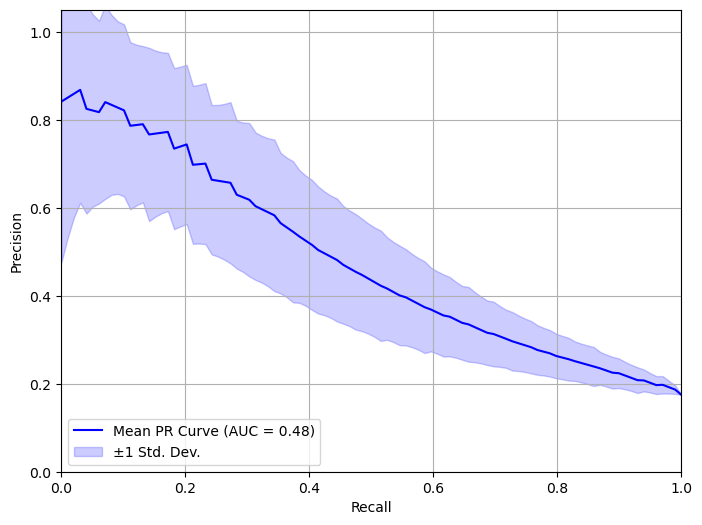

In [ ]:
# Load precision-recall data from pickle file
pr_data_path = os.path.join(os.getcwd(), 'precision_recall_data.pkl')
with open(pr_data_path, 'rb') as f:
    pr_data = pickle.load(f)

# Extract precision, recall, and AUC lists
precision_list = pr_data["precision_list"]
recall_list = pr_data["recall_list"]
auc_list = pr_data["auc_list"]

# Calculate mean and standard deviation for precision-recall curves
mean_recall = np.linspace(0, 1, 100)
interp_precisions = []

for precision, recall in zip(precision_list, recall_list):
    # Sort recall and precision in increasing recall order
    order = np.argsort(recall)
    recall_sorted = recall[order]
    precision_sorted = precision[order]
    
    # Interpolate precision as a function of recall
    interp_precision = np.interp(mean_recall, recall_sorted, precision_sorted, left=1.0, right=0.0)
    interp_precisions.append(interp_precision)

# Calculate mean and std of precision at each recall level
mean_precision = np.mean(interp_precisions, axis=0)
std_precision = np.std(interp_precisions, axis=0)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, label=f"Mean PR Curve (AUC = {np.mean(auc_list):.2f})", color='b')
plt.fill_between(mean_recall, mean_precision - std_precision, mean_precision + std_precision, color='b', alpha=0.2, label="±1 Std. Dev.")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower left")
plt.grid()
plt.show()